In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras import regularizers

C:\Users\martelos\AppData\Local\anaconda3\envs\env_deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\martelos\AppData\Local\anaconda3\envs\env_deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\martelos\AppData\Local\anaconda3\envs\env_deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

In [2]:
import warnings
#warnings.filterwarnings('ignore')

In [3]:
figureSize                      = (20,14)

In [4]:
pd.set_option('display.max_columns',100)
pd.set_option('display.min_rows',10)
pd.set_option('display.max_rows',1000)
pd.set_option('display.width',200)
pd.set_option('expand_frame_repr',100)
pd.set_option('display.max_colwidth',100)

In [50]:
def write_Metrics(model,log_rgr,lossFunctionHist,train_loss,test_loss,lifeCycle_loss,modelName) -> None:
    """
    Function for saving resuls of the loss and error metrics
    """
    lossVec     = log_rgr.history["loss"]
    val_lossVec = log_rgr.history["val_loss"]
    maeVec      = log_rgr.history[lossFunctionHist[0]]
    val_maeVec  = log_rgr.history[val_lossFunctionHist[0]]
    mseVec      = log_rgr.history[lossFunctionHist[1]]
    val_mseVec  = log_rgr.history[val_lossFunctionHist[1]]
    rmseVec     = log_rgr.history[lossFunctionHist[2]]
    val_rmseVec = log_rgr.history[val_lossFunctionHist[2]]
    label       = lossFunctionHist
    #
    resultsLog = [
    f'\nloss [N] in training stage: {train_loss[0]:.2f}',
    f'\nloss [N] in testing stage: {test_loss[0]:.2f}',
    f'\nloss [N] in life cycle: {lifeCycle_loss[0]:.2f}',
    f'\n{lossFunctionHist[0].replace("_"," ").title()} [N] in training stage: {train_loss[1]:.2f}',
    f'\n{lossFunctionHist[0].replace("_"," ").title()} [N] in testing stage: {test_loss[1]:.2f}',
    f'\n{lossFunctionHist[0].replace("_"," ").title()} [N] in life cycle: {lifeCycle_loss[1]:.2f}',
    #
    f'\n{lossFunctionHist[1].replace("_"," ").title()} [N] in training stage: {train_loss[2]:.2f}',
    f'\n{lossFunctionHist[1].replace("_"," ").title()} [N] in testing stage: {test_loss[2]:.2f}',
    f'\n{lossFunctionHist[1].replace("_"," ").title()} [N] in life cycle: {lifeCycle_loss[2]:.2f}',
    #
    f'\n{lossFunctionHist[2].replace("_"," ").title()} [N] in training stage: {train_loss[3]:.2f}',
    f'\n{lossFunctionHist[2].replace("_"," ").title()} [N] in testing stage: {test_loss[3]:.2f}',
    f'\n{lossFunctionHist[2].replace("_"," ").title()} [N] in life cycle: {lifeCycle_loss[3]:.2f}'
    ]
    #
    #saving results
    fileName = f"{modelName}.txt"
    with open(fileName, "w") as modelScoreTxt:
        modelScoreTxt.write(f"\nModel Name")
        print(f"\n{modelName}\n\n")
        modelScoreTxt.write(f"\n{modelName}\n\n")
        print(f"\n{modelName}\n\n")
        #modelScoreTxt.write(f"\n{str(model.summary())}\n\n")        
        for message in resultsLog:
            modelScoreTxt.write(message)
            print(message)

In [6]:

def plot_epoch_vs_loss(lossVec,val_lossVec,label,figName,figureSize)->None:
    """Function for plotting loss or error metrics vs epoch number. This way one can visualiza the evolution
    the los / cost function or any error metric with the epoch number (number of times the model has seen all the training data)
    """
    epoch = range(1,len(lossVec)+1)
    fig, ax = plt.subplots(figsize = figureSize)
    plt.plot(epoch,lossVec,label = "Training Stage")
    plt.plot(epoch,val_lossVec,label = "Cross Validation Stage")
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.minorticks_on()
    plt.grid()
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=7, color='orange')
    #
    plt.xlabel('Epoch number',fontsize=20)
    plt.ylabel(f'{label.replace("_"," ").title()} [N]',fontsize=20)
    plt.title('Training Stage',fontsize=30)
    #
    #2 hidden layer
    plt.savefig(f'{label}_{figName}')
#

In [7]:
def plot_ml_regressor_predictionVStarget_values(figureSize,label,predictions_train, y_train,predictions_test, y_test) -> None:
    """
    function for ploting the predicted tensions by machine models against target values, 
    obtained with simulations or meassurements
    """
    fig, ax = plt.subplots(figsize = figureSize)
    ##plt.plot(predictions_train, y_train, "+", color="blue",linestyle="--",alpha = 0.7)
    ##plt.plot(predictions_test, y_test, "^", color="red",linestyle="--",alpha = 0.7)
    #plt.plot(predictions_train, y_train, "+", color="blue",alpha = 0.7)
    #plt.plot(predictions_test, y_test, "^", color="red",alpha = 0.7)
    plt.scatter(y_train.reset_index(drop=True),predictions_train, color="blue",marker = "+",alpha=0.7)
    plt.scatter(y_test.reset_index(drop=True),predictions_test, color="red", marker = "^",alpha=0.7)
    #plt.legend(["Traning Stage","Validation Stage"],loc=2,prop={'size':22})
    plt.legend(["Traning Stage","Validation Stage"],prop={'size':22})
    #
    plt.xlim(min(min(predictions_train),min(predictions_test)),max(max(predictions_train),max(predictions_test)))
    plt.ylim(min(min(predictions_train),min(predictions_test)),max(max(predictions_train),max(predictions_test)))
    #plt.xticks(range(100,220,20))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.minorticks_on()
    plt.grid()
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=7, color='orange')
    #
    plt.xlabel('ML Tension Predictions [N]',fontsize=20)
    plt.ylabel('FEBO Tension Predictions [N]',fontsize=20)
    plt.title('Tension Prediction Comparison',fontsize=30)
    #
    plt.savefig(f'{label}_predicted_vs_simulated.png')

In [8]:
def plot_ml_regressor_lifeCycle_predictionVStarget_values(figureSize,label,prediction_lifeCycle, y_lifeCycle) -> None:
    """
    function for ploting the Life Cycle predicted tensions by machine models against target values, 
    obtained with simulations or meassurements
    """
    fig, ax = plt.subplots(figsize = figureSize)
    ##plt.plot(predictions_train, y_train, "+", color="blue",linestyle="--",alpha = 0.7)
    ##plt.plot(predictions_test, y_test, "^", color="red",linestyle="--",alpha = 0.7)
    #plt.plot(predictions_lifeCycle, y_lifeCycle, "^", color="red",alpha = 0.7)
    #plt.plot(y_lifeCycle, y_lifeCycle, "+", color="blue",alpha = 0.7)
    plt.scatter(y_lifeCycle.reset_index(drop=True),prediction_lifeCycle, color="red", marker = "^",alpha=0.7)
    plt.scatter(y_lifeCycle.reset_index(drop=True),y_lifeCycle.reset_index(drop=True), color="blue", marker = "^",alpha=0.7)
    #plt.legend(["Traning Stage","Validation Stage"],loc=2,prop={'size':22})
    plt.legend(["Life Cycle Values vs ML Predictions","Life Cycle Values"],prop={'size':22})
    #
    plt.xlim(min(min(y_lifeCycle),min(predictions_lifeCycle)),max(max(predictions_train),max(y_lifeCycle)))
    plt.ylim(min(min(y_lifeCycle),min(predictions_lifeCycle)),max(max(predictions_train),max(y_lifeCycle)))
    #plt.xticks(range(100,220,20))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.minorticks_on()
    plt.grid()
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=7, color='orange')
    #
    plt.xlabel('ML Tension Predictions [N]',fontsize=20)
    plt.ylabel('FEBO Tension Predictions [N]',fontsize=20)
    plt.title('Tension Prediction Comparison',fontsize=30)
    #
    plt.savefig(f'{label}_predicted_vs_simulated.png')

In [9]:
def plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,labelFigure,predictions,y,titleText) -> None:
    """
    function for ploting the predicted tensions by machine models against target values, 
    obtained with simulations or meassurements
    """
    fig, ax = plt.subplots(figsize = figureSize)
    #pd.Series(y).reset_index(drop=True).plot()
    #pd.Series(predictions).plot()
    plt.plot(y.reset_index(drop=True), linewidth=1, marker = "+")
    plt.plot(predictions, linewidth=1, marker = "^",alpha=0.7)    
    plt.legend(["FEBO","ML"],prop={'size':22})
    #
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.minorticks_on()
    plt.grid()
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=7, color='orange')
    #
    plt.xlabel('Sample ID',fontsize=20)
    plt.ylabel('Tension Predictions [N]',fontsize=20)
    plt.title(f'{titleText.replace("_"," ")} Tension Prediction',fontsize=30) #Validation Stage
    #
    plt.savefig(f'{labelFigure}_predicted_vs_simulated_{titleText}.png')

In [10]:

def scoringTest(model,X_train, y_train,X_test, y_test,label): 
    # R^2 Pearson's coefficient
    R2_train = r2_score(predictions_train, y_train)
    R2_test = r2_score(predictions_test, y_test)
    modelScore_train = model.score(X_train, y_train)
    modelScore_test = model.score(X_test, y_test)
    mea_train = mean_absolute_error(predictions_train, y_train)# mea : mean absolute error
    mea_test  = mean_absolute_error(predictions_test, y_test)
    rmse_train = np.sqrt(mean_squared_error(predictions_train, y_train))# rmse : Root mean square error
    rmse_test  = np.sqrt(mean_squared_error(predictions_test, y_test))
    #
    resultsLog = [
    f"Scoring results for model {label}",
    f"model: {model}",
    f"number of sampples: {n_samples}",
    f"R2 in training stage: {modelScore_train:.3f}",
    f"R2 in testing stage: {modelScore_test:.3f}",
    f"Pearson's coefficient in training stage: {R2_train:.3f}",
    f"Pearson's coefficient in testing stage: {R2_test:.3f}",
    f"Mean absolute error in training stage: {mea_train:.3f}",
    f"Mean root square error in training stage: {rmse_train:.3f}",
    f"Mean absolute error in testing stage: {mea_test:.3f}",
    f"Root mean square error in testing stage: {rmse_test:.3f}"
    ]
    #
    featureWeights = pd.DataFrame(
                            {'predictor': list(X.columns),
                             'importancia': model.feature_importances_}
                            )
    #
    #saving results
    fileName = f"{label}.txt"
    with open(fileName, "w") as modelScoreTxt:
        for message in resultsLog:
            modelScoreTxt.write(message)
            print(message)
    #
    featureWeights.sort_values('importancia', ascending=False)
    print(featureWeights.sort_values('importancia', ascending=False))
    #
    return modelScore_train,modelScore_test,R2_train,R2_test,mea_train,mea_test,rmse_train,rmse_test,featureWeights

In [11]:
def scoringTestLifeCycle(model,predictions_lifeCycle,  y_lifeCycle,label): 
    # R^2 Pearson's coefficient
    R2_test = r2_score(predictions_lifeCycle, y_lifeCycle)
    modelScore_test = model.score(X_lifeCycle, y_lifeCycle)
    mea_test  = mean_absolute_error(predictions_lifeCycle, y_lifeCycle)
    rmse_test  = np.sqrt(mean_squared_error(predictions_lifeCycle, y_lifeCycle))
    #
    resultsLog = [
    f"Scoring results for model {label}",
    f"model: {model}",
    f"number of sampples: {n_samples}",
    f"R2 in testing stage: {modelScore_test:.3f}",
    f"Pearson's coefficient in testing stage: {R2_test:.3f}",
    f"Mean absolute error in testing stage: {mea_test:.3f}",
    f"Root mean square error in testing stage: {rmse_test:.3f}"
    ]
    #saving results
    fileName = f"{label}.txt"
    with open(fileName, "w") as modelScoreTxt:
        for message in resultsLog:
            modelScoreTxt.write(message)
            print(message)
    #
    return modelScore_test,R2_test,mea_test,rmse_test

In [12]:
def colNames(label,numberOfLines,flg):
    testingFeature                                   = label
    testingFeature_windHeading                       = f"{testingFeature}_WindHead_[degrees]"
    if(flg < 1):
        testingFeature_windSpeed                         = f"{testingFeature}_WindStSpeed_[m_s]"
        testingFeature_squareWindSpeed                   = f"{testingFeature}_SquareWindStSpeed_[m_s]^2"
    else:
        testingFeature_windSpeed                         = f"{testingFeature}_WindStSpeed_[m/s]"
        testingFeature_squareWindSpeed                   = f"{testingFeature}_SquareWindStSpeed_[m/s]^2"        
    testingFeature_timeStep                          = f"{testingFeature}_timeStep"
    testingFeature_mooring_system_mean_total_tension = f"{testingFeature}_mooring_system_mean_total_tension"
    testingFeature_mooring_system_max_total_tension  = f"{testingFeature}_mooring_system_max_total_tension"
    testingFeature_mooring_line_max_tension          = f"{testingFeature}_mooring_line_max_tension"
    testingFeature_mooring_line_max_tension_id       = f"{testingFeature}_mooring_line_max_tension_id"
    #
    # adding extra columns for tracking the max tensions in each line
    testingFeature_mooring_line_vec_mean_tension    = [ f"{testingFeature}_mooring_line_{kk}_mean_tension" for kk in range(numberOfLines) ]
    testingFeature_mooring_line_vec_max_tension     = [ f"{testingFeature}_mooring_line_{kk}_max_tension" for kk in range(numberOfLines) ]
    #
    testingFeature_mean_surge                       = f"{testingFeature}_mean_surge"
    testingFeature_max_surge                        = f"{testingFeature}_max_surge"
    testingFeature_max_surge_id                     = f"{testingFeature}_max_surge_id"
    testingFeature_mean_sway                        = f"{testingFeature}_mean_sway"
    testingFeature_max_sway                         = f"{testingFeature}_max_sway"
    testingFeature_max_sway_id                      = f"{testingFeature}_max_sway_id"
    testingFeature_mean_yaw                         = f"{testingFeature}_mean_yaw"
    testingFeature_max_yaw                          = f"{testingFeature}_max_yaw"
    testingFeature_max_yaw_id                       = f"{testingFeature}_max_yaw_id"
    testingFeature_min_surge                        = f"{testingFeature}_min_surge"
    testingFeature_min_surge_id                     = f"{testingFeature}_min_surge_id"
    testingFeature_min_sway                         = f"{testingFeature}_min_sway"
    testingFeature_min_sway_id                      = f"{testingFeature}_min_sway_id"
    testingFeature_min_yaw                          = f"{testingFeature}_min_yaw"
    testingFeature_min_yaw_id                       = f"{testingFeature}_min_yaw_id"
    testingFeature_describe                         = f"{testingFeature}_describe"
    #
    testingFeature_id                               = f"{testingFeature}_id" # index of case items contained in each parent folder
    df_cols_Features   = [testingFeature_id,testingFeature_windSpeed,testingFeature_squareWindSpeed,testingFeature_windHeading]
    df_cols_maxTarget  = [testingFeature_max_surge,testingFeature_min_surge,testingFeature_max_sway,testingFeature_min_sway,testingFeature_max_yaw,testingFeature_min_yaw,testingFeature_mooring_system_max_total_tension]
    df_cols_meanTarget = [testingFeature_mean_surge,testingFeature_mean_sway,testingFeature_mean_yaw,testingFeature_mooring_system_mean_total_tension]
    for kk in range(numberOfLines):
        df_cols_meanTarget.append(testingFeature_mooring_line_vec_mean_tension[kk])
        df_cols_maxTarget.append(testingFeature_mooring_line_vec_max_tension[kk])
    
    return df_cols_Features,df_cols_maxTarget,df_cols_meanTarget



In [13]:
##################################################################################
##################################################################################
# Function for reading a csv file delimited by semi colons
def get_csv101x(path,rows,separator):
    # Best practice of how to read csv files
    print("\n\n# ======================================================== #\n")
    print(f"READING FILE: {path}")
    # Best practice of how to read csv files
    df_input = pd.read_csv(
        path,  # file name
        skiprows=rows,  # skip header
        #delim_whitespace=True,  # whitespace separated
    	sep = separator
        #na_values=['-99.9', '-99.99'],  # NaNs
    )
    print(df_input.head())
    print("\n\n")
    print(df_input.tail())
    col_names = df_input.columns
    nrows , ncols = np.shape(df_input)
    print(f'Input file has {nrows} rows and {ncols} columns')
    print(df_input.info())
    #print(df_input.describe())
    print("\n\n# ======================================================== #\n")
    print("\nInput file information loaded")
    return df_input,col_names,nrows , ncols
#
#
#
##################################################################################
##################################################################################

In [14]:
"""
Loading results
"""
label = "b_30_years"
#path_pkl = f"{label}_maxFeatures.pkl"
path_pkl = f"{label}_maxFeatures.csv"
#data = pd.read_pickle(f"../../{path_pkl}")
#data = pd.read_csv(f"../../{path_pkl}")
data,col_names,data_nrows ,ncols = get_csv101x(f"../../{path_pkl}",0,";")
#print("Displaying pickle file")
print("Displaying csv file")
#print(data)
#print(data.info())
print(data.describe())



# ======================================================== #

READING FILE: ../../b_30_years_maxFeatures.csv
   Unnamed: 0  b_30_years_id  b_30_years_TimeStamp  b_30_years_Year  b_30_years_Month  b_30_years_Day  b_30_years_Hour  b_30_years_WindStSpeed_[m_s]  b_30_years_SquareWindStSpeed_[m_s]^2  \
0           0              0           734262.3750             2010                 5              15               12                     10.684877                            114.166602   
1           1              1           734364.9583             2010                 8              15               12                      0.020153                              0.000406   
2           2              2           735894.4167             2014                10              15               12                      4.823057                             23.261876   
3           3              3           727114.3333             1990                10              15               12           

In [15]:
ramdomState = 42 # -> R^2_test = 1.00, R^2_test = 0.98 in decision trees
shuffleFlag = True #False -> R^2_test = 1.00, R^2_test = 0.98 in decision trees
testSize = 0.30 # 0.2 -> R^2_test = 1.00, R^2_test = 0.98 in decision trees
numberOfLines                                    = 11 + 12 + 11 + 12
testingFeature                                   = label
maximumTension = 2.97e4 #[N] folch_nylon_14mm.mc
safetyMargin = .07
#
df_cols_Features,df_cols_maxTarget,df_cols_meanTarget   = colNames(testingFeature,numberOfLines,1)
#targetColumn = df_cols_maxTarget[-1] #Tensions in mooring line 45
#targetColumn = df_cols_maxTarget[-40] #Tensions in mooring line 5
#targetColumn = df_cols_maxTarget[-29] #Tensions in mooring line 17
#targetColumn = df_cols_maxTarget[-17] #Tensions in mooring line 29
targetColumn = df_cols_maxTarget[-5] #Tensions in mooring line 41
print(targetColumn)

b_30_years_mooring_line_41_max_tension


Detectamos que hay NaN y procedemos a eliminarlos:

In [16]:
for i in data.columns:
    print(str(i)+ ": " + str(data[i].isnull().sum()))

Unnamed: 0: 0
b_30_years_id: 0
b_30_years_TimeStamp: 0
b_30_years_Year: 0
b_30_years_Month: 0
b_30_years_Day: 0
b_30_years_Hour: 0
b_30_years_WindStSpeed_[m_s]: 0
b_30_years_SquareWindStSpeed_[m_s]^2: 0
b_30_years_WindHead_[degrees]: 0
b_30_years_max_surge: 0
b_30_years_min_surge: 0
b_30_years_max_sway: 0
b_30_years_min_sway: 0
b_30_years_max_yaw: 0
b_30_years_min_yaw: 0
b_30_years_mooring_system_max_total_tension: 0
b_30_years_mooring_line_0_max_tension: 0
b_30_years_mooring_line_1_max_tension: 0
b_30_years_mooring_line_2_max_tension: 0
b_30_years_mooring_line_3_max_tension: 0
b_30_years_mooring_line_4_max_tension: 0
b_30_years_mooring_line_5_max_tension: 0
b_30_years_mooring_line_6_max_tension: 0
b_30_years_mooring_line_7_max_tension: 0
b_30_years_mooring_line_8_max_tension: 0
b_30_years_mooring_line_9_max_tension: 0
b_30_years_mooring_line_10_max_tension: 0
b_30_years_mooring_line_11_max_tension: 0
b_30_years_mooring_line_12_max_tension: 0
b_30_years_mooring_line_13_max_tension: 0
b

In [17]:
data = data.dropna()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 63 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Unnamed: 0                                   10000 non-null  int64  
 1   b_30_years_id                                10000 non-null  int64  
 2   b_30_years_TimeStamp                         10000 non-null  float64
 3   b_30_years_Year                              10000 non-null  int64  
 4   b_30_years_Month                             10000 non-null  int64  
 5   b_30_years_Day                               10000 non-null  int64  
 6   b_30_years_Hour                              10000 non-null  int64  
 7   b_30_years_WindStSpeed_[m_s]                 10000 non-null  float64
 8   b_30_years_SquareWindStSpeed_[m_s]^2         10000 non-null  float64
 9   b_30_years_WindHead_[degrees]                10000 non-null  float64
 10 

In [19]:
#Threshold tension force
#maximumTension = 2.97e4 #[N] folch_nylon_14mm.mc
#safetyMargin = .07
threshold_force = maximumTension*safetyMargin #2000 #[N]
print(f"Threshold tension force {threshold_force} #[N]")
#targetColumn = df_cols_maxTarget[-1] #Tensions in mooring line 45
#print(targetColumn)
data["Nivel"] = 0
data["Nivel"][data[targetColumn] >= threshold_force] = 1
print(data["Nivel"])

Threshold tension force 2079.0 #[N]
0       1
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Nivel, Length: 10000, dtype: int64


C:\Users\martelos\AppData\Local\anaconda3\envs\env_deeplearning\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [20]:
y = data[targetColumn]
#X = data[df_cols_Features]   
#X = data[testingFeature_id,testingFeature_windSpeed,testingFeature_squareWindSpeed,testingFeature_windHeading]
testingFeature_squareWindSpeed = f"{testingFeature}_SquareWindStSpeed_[m_s]^2"
testingFeature_windHeading = f"{testingFeature}_WindHead_[degrees]"
X = data[[testingFeature_squareWindSpeed,testingFeature_windHeading]]
#X = data[[testingFeature_squareWindSpeed]]
n_samples, n_features = X.shape
print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")

Number of samples: 10000
Number of features: 2


In [21]:
# With decisiion trees there is no need to scale the data
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, shuffle=shuffleFlag, random_state=ramdomState)
print(f"Shape feature matrix for training {X_train.shape}")
print(f"Shape feature matrix for testing {X_test.shape}")
print(f"Shape feature matrix for training {y_train.shape}")
print(f"Shape feature matrix for testing {y_test.shape}")
#Por defecto shuffle=True y stratify=None

Shape feature matrix for training (7000, 2)
Shape feature matrix for testing (3000, 2)
Shape feature matrix for training (7000,)
Shape feature matrix for testing (3000,)


In [22]:
#Feature matrix
X

b_30_years_SquareWindStSpeed_[m_s]^2  b_30_years_WindHead_[degrees]
0                               114.166602                     100.158581
1                                 0.000406                      87.497731
2                                23.261876                      90.887509
3                                58.662858                      83.837984
4                                13.189865                      89.392806
...                                    ...                            ...
9995                             19.033180                     359.947825
9996                             49.085817                      47.756880
9997                              1.902853                     189.182474
9998                             13.817491                      54.911675
9999                             11.812878                     300.244662

[10000 rows x 2 columns]

In [23]:
#Target Vector
print(y.max())
y

2622.0292360491985


0       2622.029236
1         42.399154
2        621.203045
3       1289.400741
4        315.627302
           ...     
9995      98.538386
9996     898.919487
9997      40.743963
9998     238.914102
9999     107.308386
Name: b_30_years_mooring_line_41_max_tension, Length: 10000, dtype: float64

In [24]:
label_lifeCycle = "b_30_years"
#path_pkl = f"{label_lifeCycle}_maxFeatures.pkl"
path_pkl = f"{label_lifeCycle}_maxFeatures.csv"
#data = pd.read_pickle(f"../../{path_pkl}")
path_lifeCycle = "C:/Users/martelos/Documents/Documents/febo/workbench/cases/LLIRIA_anchorLift_0_97m/c_resulsDir"
#data_lifeCycle = pd.read_pickle(f"{path_lifeCycle}/{path_pkl}")
data_lifeCycle,col_names,nrows , ncols = get_csv101x(f"{path_lifeCycle}/{path_pkl}",0,";")


print("Displaying pickle file with all life cycle data")
print(data_lifeCycle)
print(data_lifeCycle.info())
print(data_lifeCycle.describe())
#
testingFeature                                   = label_lifeCycle
#
df_cols_Features_label_lifeCycle,df_cols_maxTarget_label_lifeCycle,df_cols_meanTarget_label_lifeCycle   = colNames(label_lifeCycle,numberOfLines,0)
print(df_cols_Features_label_lifeCycle)
print(df_cols_maxTarget_label_lifeCycle)
print(df_cols_meanTarget_label_lifeCycle)
#targetColumn = df_cols_maxTarget[-1] #Tensions in mooring line 45
#targetColumn = df_cols_maxTarget[-40] #Tensions in mooring line 5
#targetColumn = df_cols_maxTarget[-29] #Tensions in mooring line 17
#targetColumn = df_cols_maxTarget[-17] #Tensions in mooring line 29
targetColumn_label_lifeCycle = df_cols_maxTarget_label_lifeCycle[-5] #Tensions in mooring line 41
print(targetColumn_label_lifeCycle)
#
y_lifeCycle = data_lifeCycle[targetColumn_label_lifeCycle]
#X = data_lifeCycle[df_cols_Features]   
#X = data_lifeCycle[testingFeature_id,testingFeature_windSpeed,testingFeature_squareWindSpeed,testingFeature_windHeading]
#data_lifeCycle.rename(columns = { "b_30_years_SquareWindStSpeed_[m_s]^2": "b_maxDis_SquareWindStSpeed_[m/s]^2", "b_30_years_WindHead_[degrees]": "b_maxDis_WindHead_[degrees]"},inplace=True) 
print(data_lifeCycle.columns)
X_lifeCycle = data_lifeCycle[[testingFeature_squareWindSpeed,testingFeature_windHeading]]
##X = data_lifeCycle[[testingFeature_squareWindSpeed]]
n_samples, n_features = X_lifeCycle.shape
print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")
#
X_lifeCycle_train, X_lifeCycle_test, y_lifeCycle_train, y_lifeCycle_test = train_test_split(X_lifeCycle , y_lifeCycle , test_size=testSize, shuffle=shuffleFlag, random_state=ramdomState)
print(f"Shape feature matrix for training {X_lifeCycle_train.shape}")
print(f"Shape feature matrix for testing {X_lifeCycle_test.shape}")
print(f"Shape feature matrix for training {y_lifeCycle_train.shape}")
print(f"Shape feature matrix for testing {y_lifeCycle_test.shape}")



# ======================================================== #

READING FILE: C:/Users/martelos/Documents/Documents/febo/workbench/cases/LLIRIA_anchorLift_0_97m/c_resulsDir/b_30_years_maxFeatures.csv
   Unnamed: 0  b_30_years_id  b_30_years_TimeStamp  b_30_years_Year  b_30_years_Month  b_30_years_Day  b_30_years_Hour  b_30_years_WindStSpeed_[m_s]  b_30_years_SquareWindStSpeed_[m_s]^2  \
0           0              0           725008.0000             1985                 1               1                0                      3.783710                             14.316462   
1           1              1           725008.0417             1985                 1               1                1                      3.553058                             12.624223   
2           2              2           725008.0833             1985                 1               1                2                      3.363019                             11.309898   
3           3              3           7

In [25]:
# Lets scale the model
scaler = StandardScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)
X_lifeCycle[X_lifeCycle.columns] = scaler.fit_transform(X_lifeCycle)
X_lifeCycle_train[X_lifeCycle_train.columns] = scaler.fit_transform(X_lifeCycle_train)
X_lifeCycle_test[X_lifeCycle_test.columns] = scaler.transform(X_lifeCycle_test)

C:\Users\martelos\AppData\Local\anaconda3\envs\env_deeplearning\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [26]:
"""
Lets create a neural network architeture
"""
nn_1 = 50 # number of neurons
nn_2 = 64 # number of neurons
nn_3 = 1 # number of neurons
alpha = 0.01 #0.01 # learning rate
iter = 150
batch = 25
crossVal = 0.3

lossFunction = "mae"
optimizerFunction = "adam"
metricsFunction = ["mae",tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError()]
lossFunctionHist = ['mean_absolute_error',"mean_squared_error","root_mean_squared_error"]
val_lossFunctionHist = ['val_mean_absolute_error',"val_mean_squared_error","val_root_mean_squared_error"]
activationFunction = 'relu'

In [27]:
# model instantiation
NN_rgr = Sequential()
#
# defining first layer: imput layer
#NN_rgr.add(Dense(64, input_shape=(len(X_train.columns),))) 
NN_rgr.add(Dense(nn_1, input_shape=(len(X_train.columns),))) 
# Dense = fully connected layer, 
# 64 = number of neurons, 
# input_shape = number of charestic feature to take into account 
#
# defining second layer : hidden layer
NN_rgr.add(Dense(nn_2))
NN_rgr.add(Activation(activationFunction)) # activation function relu
#
# defining third layer : ouput layer
NN_rgr.add(Dense(nn_3))
#
# selection of training / optimizer algorithm
opt = keras.optimizers.SGD(learning_rate = alpha)
#
# lets compile the model
NN_rgr.compile(loss=lossFunction, optimizer=optimizerFunction, metrics=metricsFunction)
# loss function = mae (Mean Absolute Error), metrics = MAE
"""
Metric functions are similar to loss functions, except that the results from evaluating a metric 
are not used when training the model. Note that you may use any loss function as a metric.
"""

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


'\nMetric functions are similar to loss functions, except that the results from evaluating a metric \nare not used when training the model. Note that you may use any loss function as a metric.\n'

In [28]:
# lets train the neural network
log_rgr = NN_rgr.fit(X_train,y_train,
                    validation_split = crossVal,
                    batch_size = batch,
                    epochs = iter,
                    #shuffle = True
                    verbose = 1)
"""
batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. 
Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances 
(since they generate batches).

epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data 
provided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with 
initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations 
given by epochs, but merely until the epoch of index epochs is reached.

validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. 
The model will set apart this fraction of the training data, will not train on it, and will evaluate 
the loss and any model metrics on this data at the end of each epoch. The validation data is selected 
from the last samples in the x and y data provided, before shuffling. This argument is not supported 
when x is a dataset, generator or keras.utils.Sequence instance. If both validation_data and 
validation_split are provided, validation_data will override validation_split. validation_split 
is not yet supported with tf.distribute.experimental.ParameterServerStrategy.

validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model 
will not be trained on this data. Thus, note the fact that the validation loss of data provided using validation_split 
or validation_data is not affected by regularization layers like noise and dropout. validation_data will override 
validation_split. validation_data could be: - A tuple (x_val, y_val) of Numpy arrays 
or tensors. - A tuple (x_val, y_val, val_sample_weights) of NumPy arrays. - A tf.data.Dataset. - A Python generator or 
keras.utils.Sequence returning (inputs, targets) or (inputs, targets, sample_weights). validation_data is not yet 
supported with tf.distribute.experimental.ParameterServerStrategy

"""

Train on 4900 samples, validate on 2100 samples
Epoch 1/150
4900/4900 [==============================] - 0s 28us/sample - loss: 192.1548 - mean_absolute_error: 192.1548 - mean_squared_error: 128752.6562 - root_mean_squared_error: 358.8212 - val_loss: 168.0582 - val_mean_absolute_error: 168.0582 - val_mean_squared_error: 121107.6406 - val_root_mean_squared_error: 348.0052
Epoch 2/150
4900/4900 [==============================] - 0s 20us/sample - loss: 129.9977 - mean_absolute_error: 129.9977 - mean_squared_error: 75881.2891 - root_mean_squared_error: 275.4656 - val_loss: 95.2270 - val_mean_absolute_error: 95.2270 - val_mean_squared_error: 38791.9102 - val_root_mean_squared_error: 196.9566
Epoch 3/150
4900/4900 [==============================] - 0s 17us/sample - loss: 86.0399 - mean_absolute_error: 86.0399 - mean_squared_error: 25789.6113 - root_mean_squared_error: 160.5914 - val_loss: 77.8744 - val_mean_absolute_error: 77.8744 - val_mean_squared_error: 21129.2109 - val_root_mean_squared_

4900/4900 [==============================] - 0s 16us/sample - loss: 56.0127 - mean_absolute_error: 56.0128 - mean_squared_error: 12474.6494 - root_mean_squared_error: 111.6900 - val_loss: 53.7440 - val_mean_absolute_error: 53.7440 - val_mean_squared_error: 12096.9229 - val_root_mean_squared_error: 109.9860
Epoch 27/150
4900/4900 [==============================] - 0s 16us/sample - loss: 54.5851 - mean_absolute_error: 54.5851 - mean_squared_error: 12321.6475 - root_mean_squared_error: 111.0029 - val_loss: 52.0851 - val_mean_absolute_error: 52.0851 - val_mean_squared_error: 11002.3174 - val_root_mean_squared_error: 104.8919
Epoch 28/150
4900/4900 [==============================] - 0s 14us/sample - loss: 53.1306 - mean_absolute_error: 53.1306 - mean_squared_error: 11559.8877 - root_mean_squared_error: 107.5169 - val_loss: 50.6973 - val_mean_absolute_error: 50.6973 - val_mean_squared_error: 10631.1172 - val_root_mean_squared_error: 103.1073
Epoch 29/150
4900/4900 [==========================

Epoch 52/150
4900/4900 [==============================] - 0s 16us/sample - loss: 31.0164 - mean_absolute_error: 31.0164 - mean_squared_error: 3737.4375 - root_mean_squared_error: 61.1346 - val_loss: 30.7895 - val_mean_absolute_error: 30.7895 - val_mean_squared_error: 3792.3459 - val_root_mean_squared_error: 61.5820
Epoch 53/150
4900/4900 [==============================] - 0s 17us/sample - loss: 30.5998 - mean_absolute_error: 30.5998 - mean_squared_error: 3698.0042 - root_mean_squared_error: 60.8112 - val_loss: 29.8624 - val_mean_absolute_error: 29.8624 - val_mean_squared_error: 3555.6589 - val_root_mean_squared_error: 59.6293
Epoch 54/150
4900/4900 [==============================] - 0s 17us/sample - loss: 30.0786 - mean_absolute_error: 30.0786 - mean_squared_error: 3545.3330 - root_mean_squared_error: 59.5427 - val_loss: 29.7047 - val_mean_absolute_error: 29.7047 - val_mean_squared_error: 3445.5432 - val_root_mean_squared_error: 58.6987
Epoch 55/150
4900/4900 [=========================

Epoch 78/150
4900/4900 [==============================] - 0s 19us/sample - loss: 22.1507 - mean_absolute_error: 22.1507 - mean_squared_error: 1775.2739 - root_mean_squared_error: 42.1340 - val_loss: 21.3223 - val_mean_absolute_error: 21.3223 - val_mean_squared_error: 1872.2893 - val_root_mean_squared_error: 43.2700
Epoch 79/150
4900/4900 [==============================] - 0s 16us/sample - loss: 21.9316 - mean_absolute_error: 21.9316 - mean_squared_error: 1736.9626 - root_mean_squared_error: 41.6769 - val_loss: 21.1217 - val_mean_absolute_error: 21.1217 - val_mean_squared_error: 1787.8604 - val_root_mean_squared_error: 42.2831
Epoch 80/150
4900/4900 [==============================] - 0s 16us/sample - loss: 21.6591 - mean_absolute_error: 21.6591 - mean_squared_error: 1700.0198 - root_mean_squared_error: 41.2313 - val_loss: 21.1685 - val_mean_absolute_error: 21.1685 - val_mean_squared_error: 1800.9639 - val_root_mean_squared_error: 42.4378
Epoch 81/150
4900/4900 [=========================

Epoch 104/150
4900/4900 [==============================] - 0s 16us/sample - loss: 18.2935 - mean_absolute_error: 18.2935 - mean_squared_error: 1050.8938 - root_mean_squared_error: 32.4175 - val_loss: 17.9173 - val_mean_absolute_error: 17.9173 - val_mean_squared_error: 1137.0828 - val_root_mean_squared_error: 33.7207
Epoch 105/150
4900/4900 [==============================] - ETA: 0s - loss: 18.1081 - mean_absolute_error: 18.1081 - mean_squared_error: 1041.2784 - root_mean_squared_error: 32.26 - 0s 13us/sample - loss: 18.1575 - mean_absolute_error: 18.1575 - mean_squared_error: 1037.4564 - root_mean_squared_error: 32.2096 - val_loss: 18.5635 - val_mean_absolute_error: 18.5635 - val_mean_squared_error: 1147.4629 - val_root_mean_squared_error: 33.8742
Epoch 106/150
4900/4900 [==============================] - 0s 14us/sample - loss: 18.1726 - mean_absolute_error: 18.1726 - mean_squared_error: 1031.0461 - root_mean_squared_error: 32.1099 - val_loss: 18.6312 - val_mean_absolute_error: 18.6312

4900/4900 [==============================] - 0s 16us/sample - loss: 16.2703 - mean_absolute_error: 16.2703 - mean_squared_error: 789.2664 - root_mean_squared_error: 28.0939 - val_loss: 16.4768 - val_mean_absolute_error: 16.4768 - val_mean_squared_error: 846.5923 - val_root_mean_squared_error: 29.0963
Epoch 130/150
4900/4900 [==============================] - 0s 14us/sample - loss: 16.1200 - mean_absolute_error: 16.1200 - mean_squared_error: 772.0435 - root_mean_squared_error: 27.7857 - val_loss: 16.1208 - val_mean_absolute_error: 16.1208 - val_mean_squared_error: 852.8242 - val_root_mean_squared_error: 29.2032
Epoch 131/150
4900/4900 [==============================] - 0s 19us/sample - loss: 16.1669 - mean_absolute_error: 16.1669 - mean_squared_error: 762.2949 - root_mean_squared_error: 27.6097 - val_loss: 15.8929 - val_mean_absolute_error: 15.8929 - val_mean_squared_error: 867.3954 - val_root_mean_squared_error: 29.4516
Epoch 132/150
4900/4900 [==============================] - 0s 16us

'\nbatch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. \nDo not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances \n(since they generate batches).\n\nepochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data \nprovided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with \ninitial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations \ngiven by epochs, but merely until the epoch of index epochs is reached.\n\nvalidation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. \nThe model will set apart this fraction of the training data, will not train on it, and will evaluate \nthe loss and any model metrics on this data at the end of each epoch. The validation data is selected \nfrom 

In [29]:
print(log_rgr.history) # keys -> 'loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'

{'loss': [192.15483795866675, 129.99771394534986, 86.03990122736717, 78.79879569034188, 77.67633582134636, 77.09891565478578, 76.6200335463699, 76.12486518159204, 75.41927607205449, 74.90747044037799, 74.20001800692812, 73.54473066329956, 72.67943611923529, 71.8428215250677, 71.0131332241759, 69.83243240628924, 68.48738148747658, 67.16809855675211, 65.8587180157097, 64.33211402017243, 63.05379367361263, 61.53491436705298, 60.27315204970691, 58.851516460885804, 57.33328601292202, 56.01274636327004, 54.58509281703404, 53.13063209884021, 51.84966581694934, 50.498843229546836, 49.137860098663644, 48.00991226215752, 46.864359828890585, 45.65806041931619, 44.45071297762345, 43.33318830023006, 42.29290194900668, 41.10299272926486, 40.06840352136262, 39.17010641584591, 38.20832064686989, 37.537812169717284, 36.60170233249664, 35.78905811601756, 35.17618297070873, 34.51558239119394, 33.80339748518808, 33.2177479072493, 32.5090677640876, 31.963761548606715, 31.493177555045303, 31.016438635028138

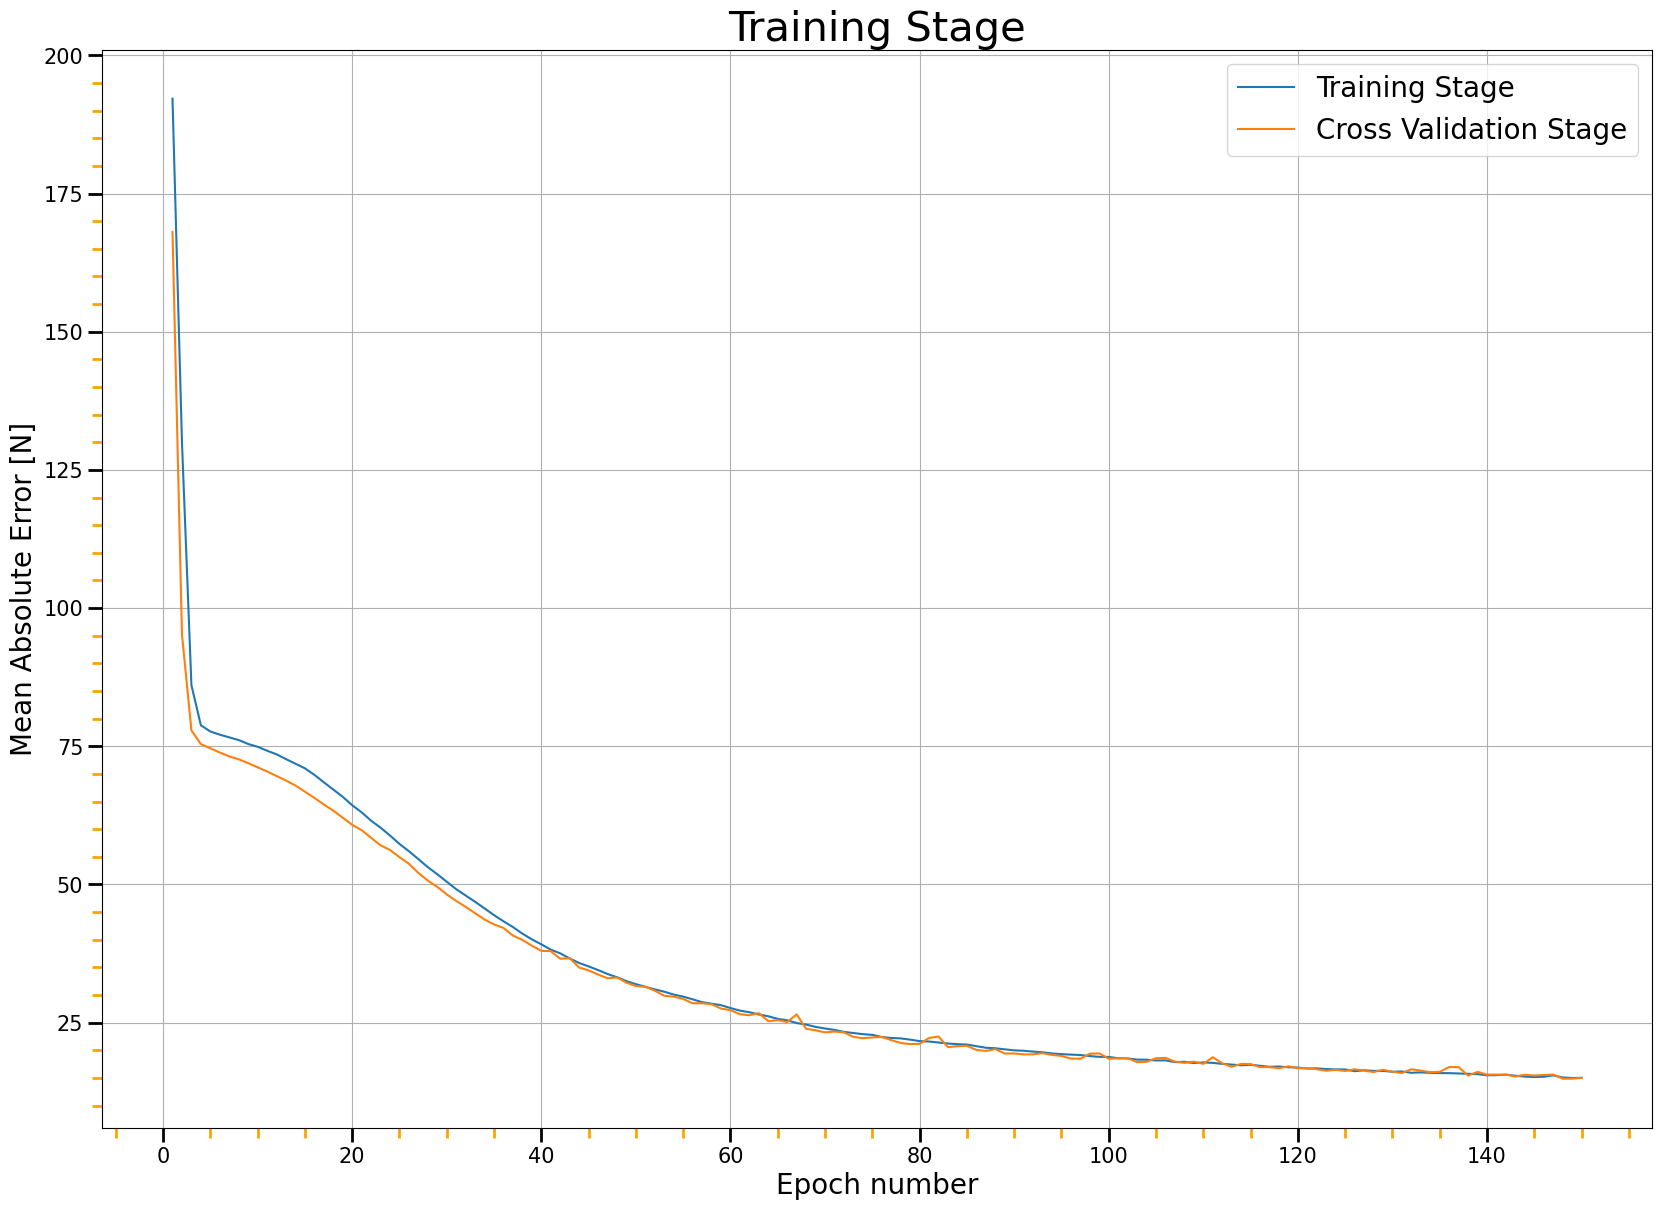

In [30]:
epoch = range(1,len(log_rgr.history[lossFunctionHist[0]])+1)
fig, ax = plt.subplots(figsize = figureSize)
plt.plot(epoch,log_rgr.history[lossFunctionHist[0]],label = "Training Stage")
plt.plot(epoch,log_rgr.history[val_lossFunctionHist[0]],label = "Cross Validation Stage")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.minorticks_on()
plt.grid()
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=7, color='orange')
#
plt.xlabel('Epoch number',fontsize=20)
plt.ylabel(f'{lossFunctionHist[0].replace("_"," ").title()} [N]',fontsize=20)
plt.title('Training Stage',fontsize=30)
plt.savefig(f"mnn_tensorflow_{nn_1}_{nn_2}_{nn_3}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v2.jpg")
#plt.savefig(f"mnn_tensorflow_{nn_1}_{nn_2}_{nn_3}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{metricsFunction}_{activationFunction}_v2.jpg")


In [51]:

# lets check for overfitting
train_loss = NN_rgr.evaluate(X_train, y_train, verbose=1)
test_loss  = NN_rgr.evaluate(X_test, y_test, verbose=1)
lifeCycle_loss = NN_rgr.evaluate(X_lifeCycle,y_lifeCycle, verbose=1)
modelName = f"mnn_tensorflow_{nn_1}_{nn_2}_{nn_3}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}"
write_Metrics(NN_rgr,log_rgr,lossFunctionHist,train_loss,test_loss,lifeCycle_loss,modelName)
"""
print(f'{lossFunctionHist[0].replace("_"," ").title()} [N] in training stage: {train_loss[0]:.2f}')
print(f'{lossFunctionHist[0].replace("_"," ").title()} [N] in testing stage: {test_loss[0]:.2f}')
print(f'{lossFunctionHist[0].replace("_"," ").title()} [N] in training stage: {lifeCycle_loss[0]:.2f}')
"""

98733/98733 [==============================] - 0s 5us/sample - loss: 89.9774 - mean_absolute_error: 89.9774 - mean_squared_error: 30479.8574 - root_mean_squared_error: 174.5848

mnn_tensorflow_50_50_50_0.01_50_32_0.1_mae_adam_relu



loss [N] in training stage: 14.73

loss [N] in testing stage: 14.50

loss [N] in life cycle: 89.98

Mean Absolute Error [N] in training stage: 14.73

Mean Absolute Error [N] in testing stage: 14.50

Mean Absolute Error [N] in life cycle: 89.98

Mean Squared Error [N] in training stage: 669.65

Mean Squared Error [N] in testing stage: 616.93

Mean Squared Error [N] in life cycle: 30479.86

Root Mean Squared Error [N] in training stage: 25.88

Root Mean Squared Error [N] in testing stage: 24.84

Root Mean Squared Error [N] in life cycle: 174.58


'\nprint(f\'{lossFunctionHist[0].replace("_"," ").title()} [N] in training stage: {train_loss[0]:.2f}\')\nprint(f\'{lossFunctionHist[0].replace("_"," ").title()} [N] in testing stage: {test_loss[0]:.2f}\')\nprint(f\'{lossFunctionHist[0].replace("_"," ").title()} [N] in training stage: {lifeCycle_loss[0]:.2f}\')\n'

In [32]:
# Now lets plot the testing data an compared it with the predictions from the neural network
predictions_train = NN_rgr.predict(X_train)
predictions_test = NN_rgr.predict(X_test)

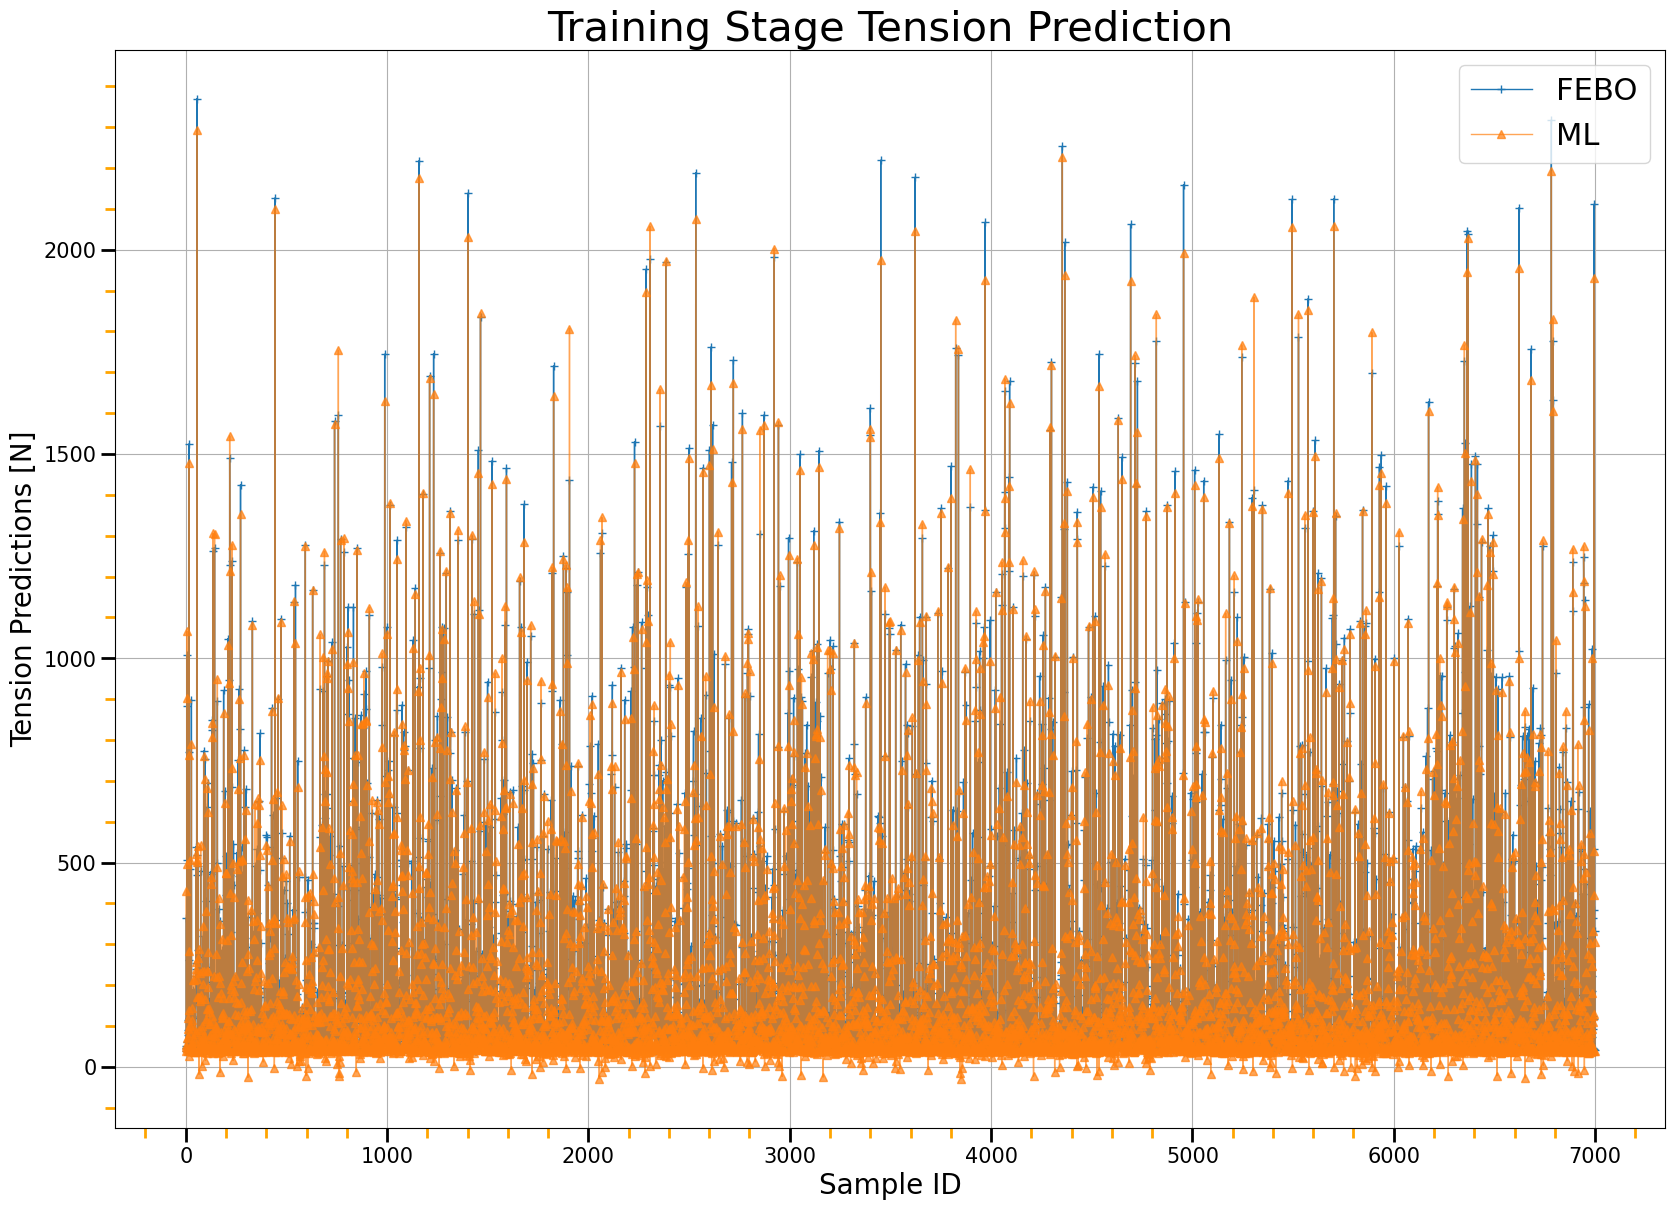

In [33]:
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v2.jpg",predictions_train, y_train,f"Training_Stage")

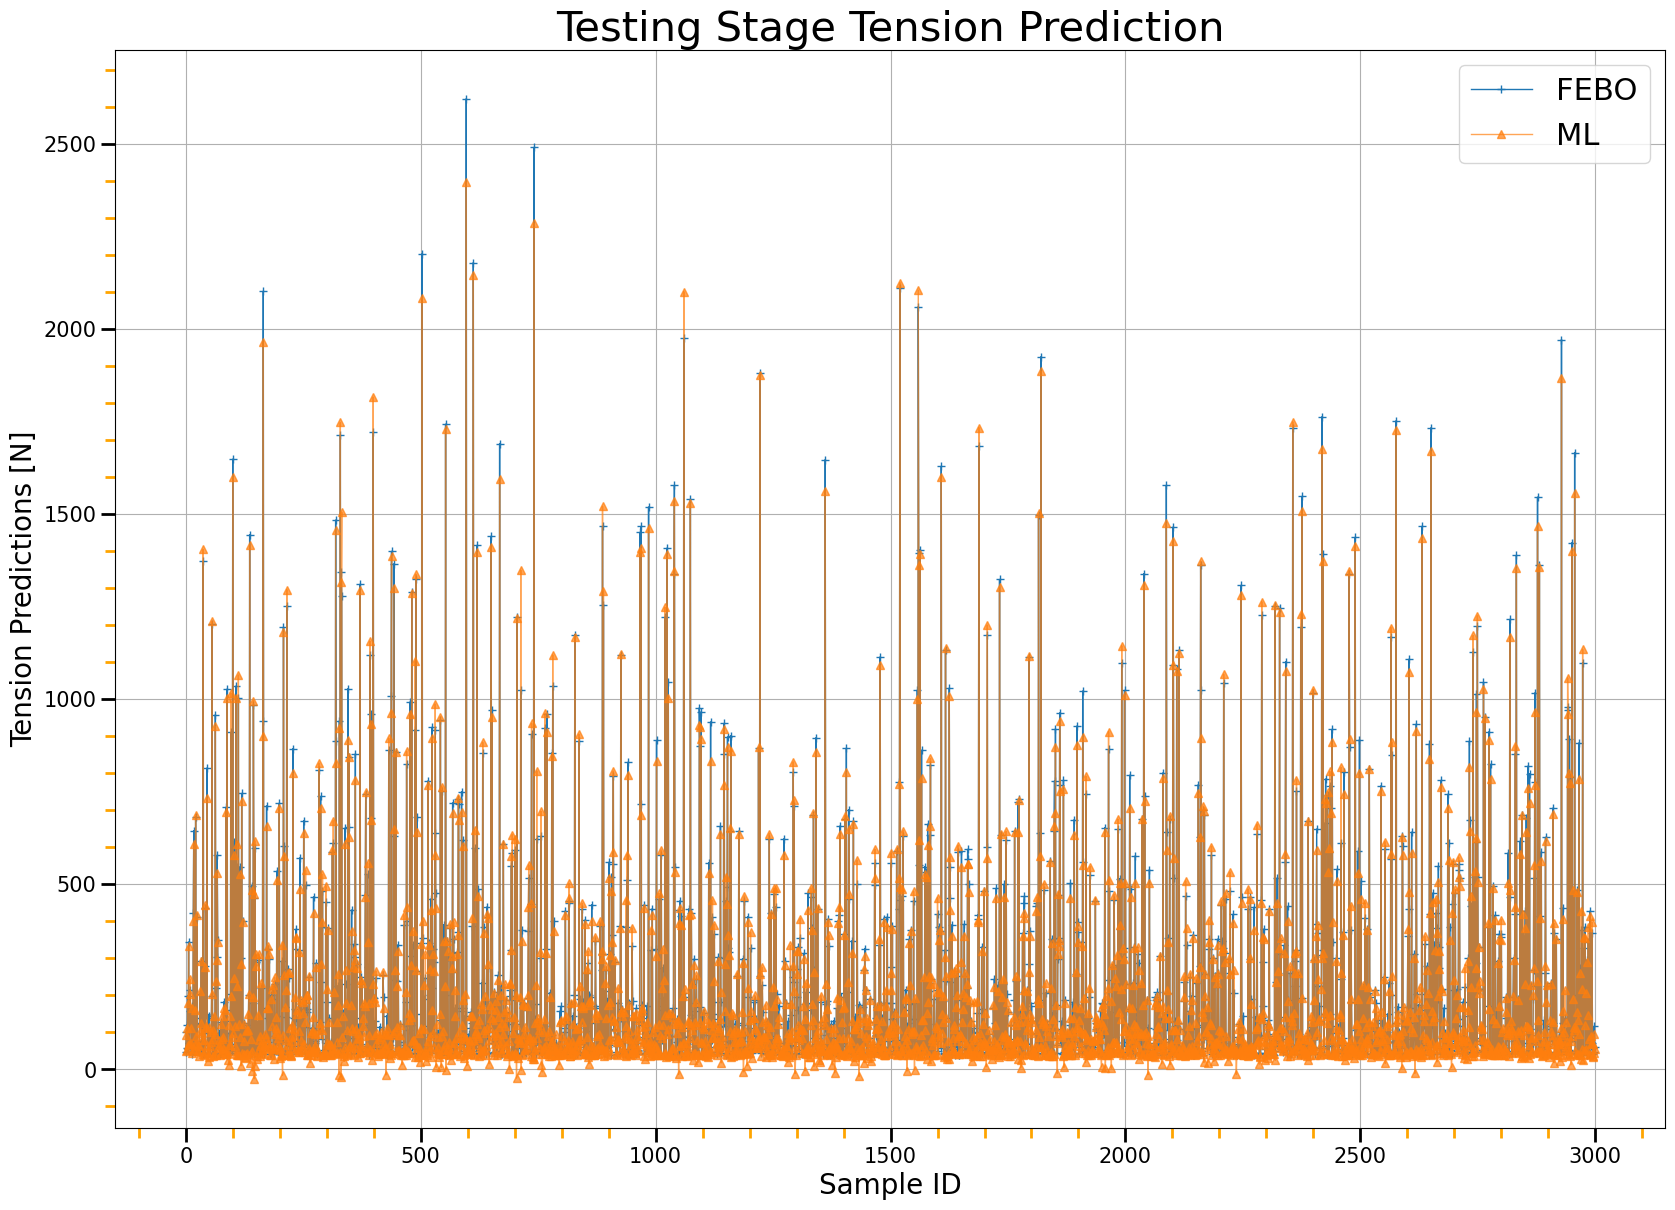

In [34]:
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v2.jpg",predictions_test, y_test,f"Testing_Stage")

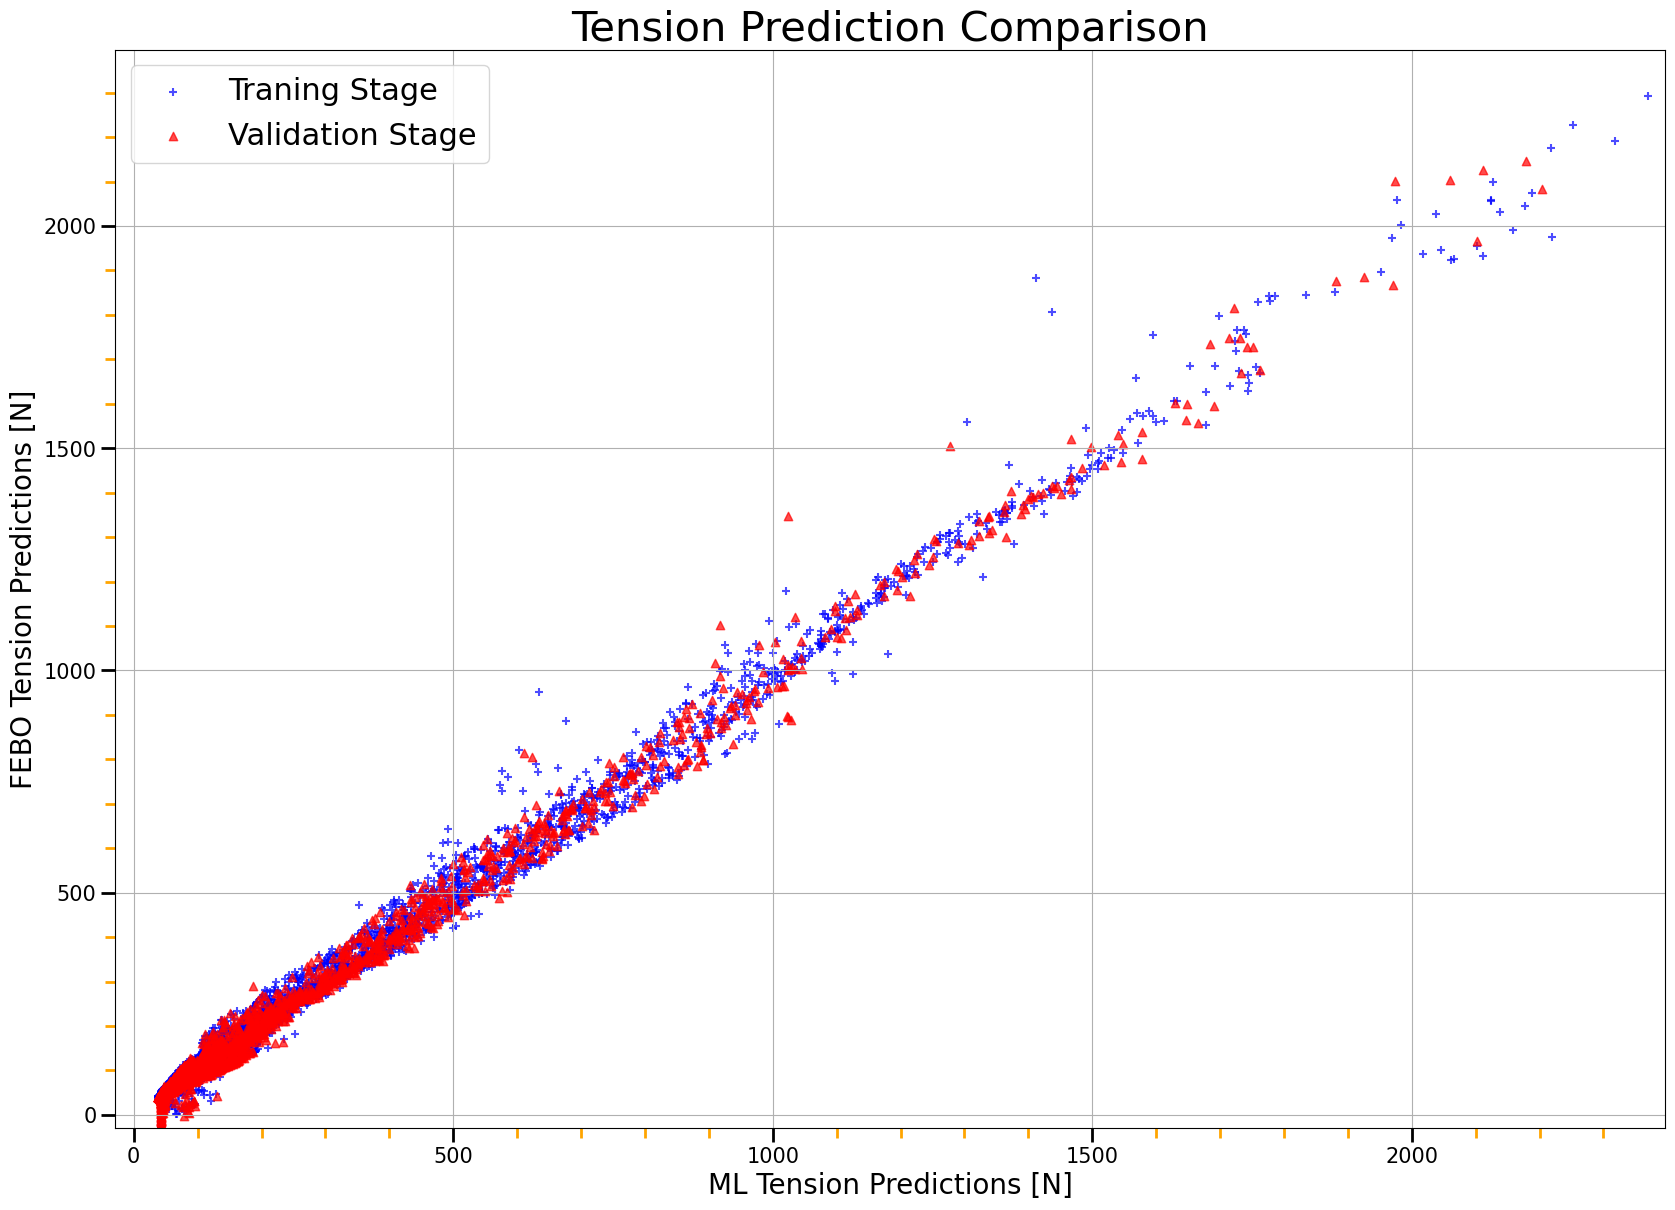

In [35]:
plot_ml_regressor_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v2.jpg",predictions_train, y_train,predictions_test, y_test)

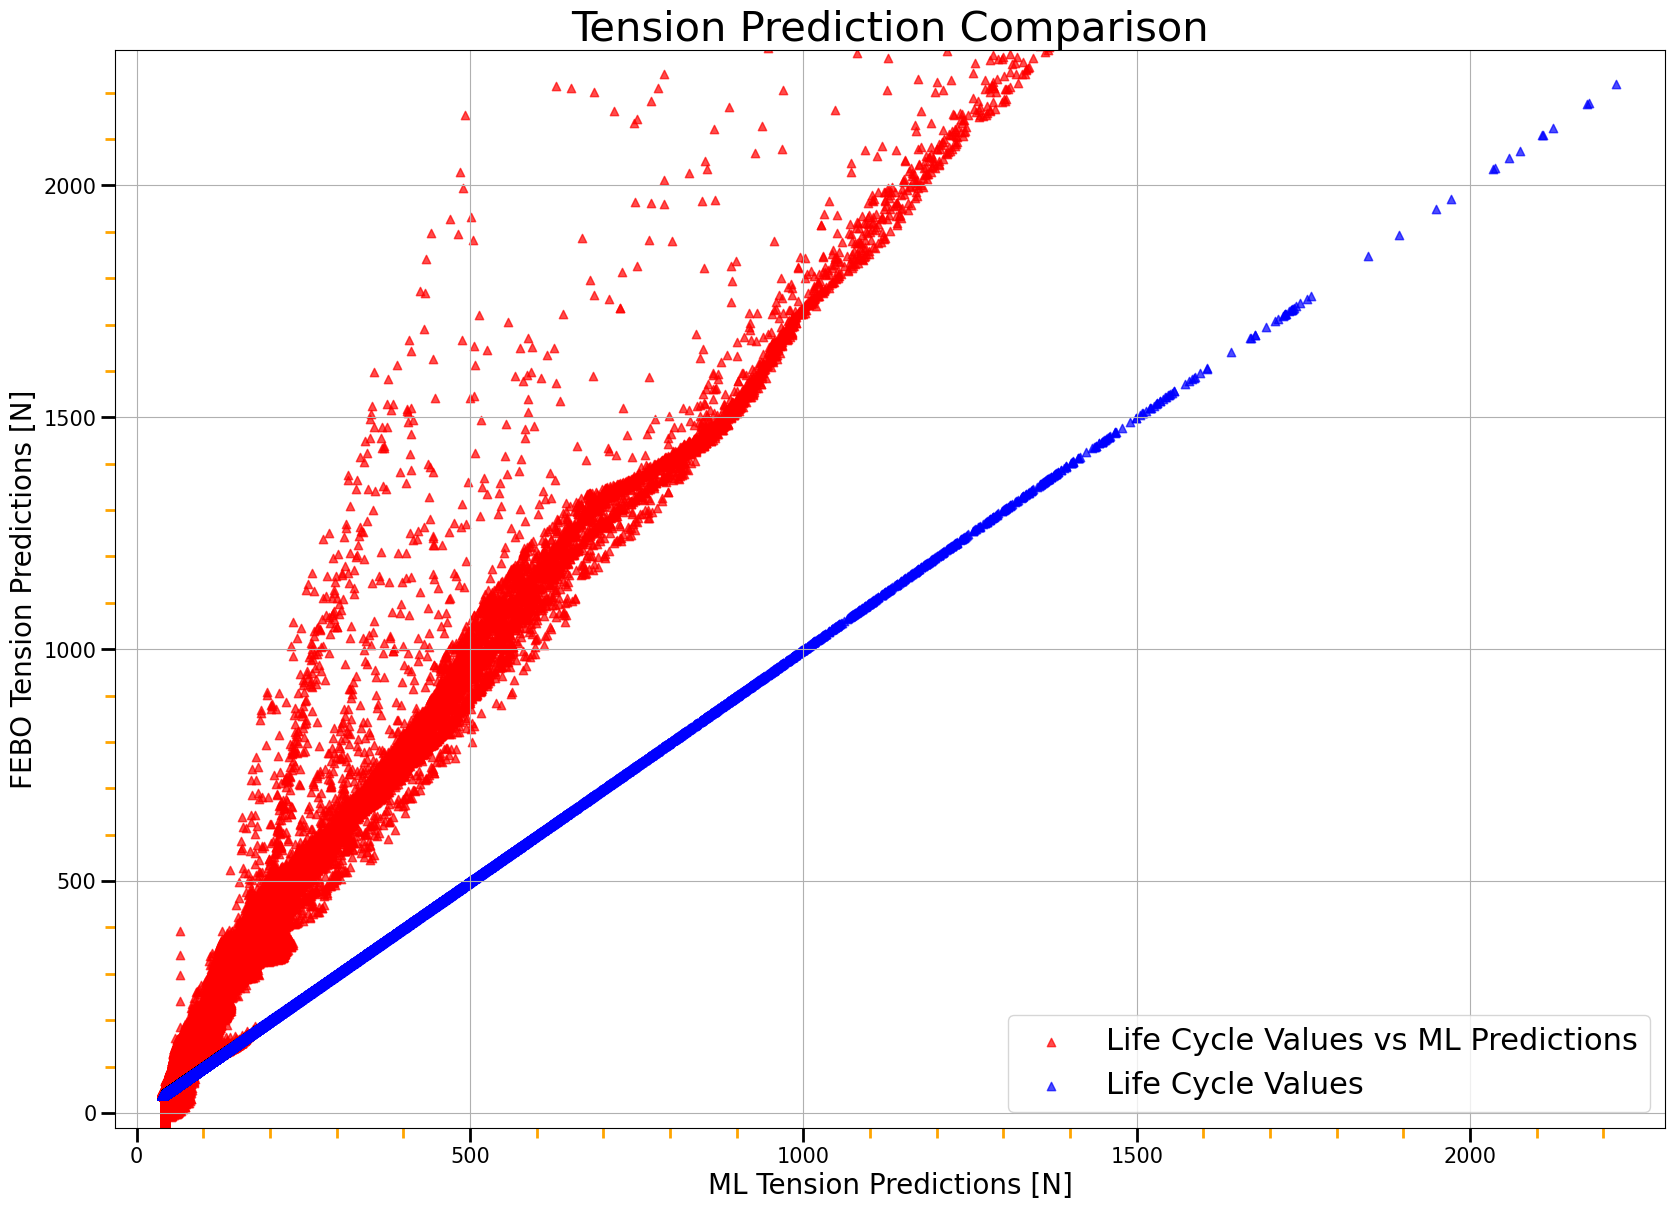

In [36]:
predictions_lifeCycle = NN_rgr.predict(X_lifeCycle)
plot_ml_regressor_lifeCycle_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_lifeCycle_{nn_1}_{nn_2}_{nn_3}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v2.jp",predictions_lifeCycle, y_lifeCycle)

In [37]:
"""
Lets create a neural network architeture with l2 regularization in order to minimize the overfitting
"""
regularization = regularizers.l2(0.01)
nn_1 = 50 # number of neurons
nn_2 = 50 # number of neurons
nn_3 = 50 # number of neurons
nn_4 = 50 # number of neurons
nn_out = 1 # number of neurons
#nn_vec = np.array([nn_1,nn_2,nn_3,nn_4])
nn_vec = np.array([nn_1,nn_2,nn_3])
alpha = 0.01 #0.01 # learning rate
dropRate = 0.05
iter = 50
batch = 32
crossVal = 0.1
lossFunction = "mae"
optimizerFunction = "adam"
metricsFunction = ["mae",tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError()]
lossFunctionHist = ['mean_absolute_error',"mean_squared_error","root_mean_squared_error"]
val_lossFunctionHist = ['val_mean_absolute_error',"val_mean_squared_error","val_root_mean_squared_error"]
activationFunction = 'relu'
# model instantiation
NN_rgr_v2 = Sequential()
#
# defining first layer: imput layer
#NN_rgr_v2.add(Dense(nn_1, input_shape=(len(X_train.columns),),kernel_regularizer=regularization,name="l_input")) 
NN_rgr_v2.add(Dense(nn_1, input_shape=(len(X_train.columns),),kernel_regularizer=regularization)) 
NN_rgr_v2.add(Activation(activationFunction))
NN_rgr_v2.add(Dropout(dropRate))  # Ajusta la tasa de dropout según tus necesidades
l_architecture = f"mnn_tensorflow_{nn_1}"
#
"""
# defining second layer : hidden layer
#NN_rgr_v2.add(Dense(nn_2,kernel_regularizer=regularization),name="l_hidden1") 
NN_rgr_v2.add(Dense(nn_2,kernel_regularizer=regularization)) 
NN_rgr_v2.add(Activation(activationFunction))
NN_rgr_v2.add(Dropout(dropRate))  # Ajusta la tasa de dropout según tus necesidades
l_architecture = f"mnn_tensorflow_{nn_1}_{nn_2}"
#
# defining third layer : hidden layer
#NN_rgr_v2.add(Dense(nn_3,kernel_regularizer=regularization),name="l_hidden2")
NN_rgr_v2.add(Dense(nn_3,kernel_regularizer=regularization))
NN_rgr_v2.add(Activation(activationFunction))
NN_rgr_v2.add(Dropout(dropRate))  # Ajusta la tasa de dropout según tus necesidades
l_architecture = f"mnn_tensorflow_{nn_1}_{nn_2}_{nn_3}"
"""
for nn_val in nn_vec[1:]:
    print("Adding an extra hidden layer")
    NN_rgr_v2.add(Dense(nn_3,kernel_regularizer=regularization))
    NN_rgr_v2.add(Activation(activationFunction))
    NN_rgr_v2.add(Dropout(dropRate))  # Ajusta la tasa de dropout según tus necesidades
    l_architecture = f"{l_architecture}_{nn_val}"
#
"""
# defining 4th layer : hidden layer
#NN_rgr_v2.add(Dense(nn_4,kernel_regularizer=regularization),name="l_hidden2")
NN_rgr_v2.add(Dense(nn_4,kernel_regularizer=regularization))
NN_rgr_v2.add(Activation(activationFunction))
NN_rgr_v2.add(Dropout(dropRate))  # Ajusta la tasa de dropout según tus necesidades
l_architecture = f"mnn_tensorflow_{nn_1}_{nn_2}_{nn_3}_{nn_4}"
"""
#
#
# defining 5th layer : ouput layer
#NN_rgr_v2.add(Dense(nn_out),name="l_output")
NN_rgr_v2.add(Dense(nn_out))
#
# selection of training / optimizer algorithm
opt = keras.optimizers.SGD(learning_rate = alpha)
#
# lets compile the model
NN_rgr_v2.compile(loss=lossFunction, optimizer=optimizerFunction, metrics=metricsFunction)
# loss function = mae (Mean Absolute Error), metrics = MAE
"""
Metric functions are similar to loss functions, except that the results from evaluating a metric 
are not used when training the model. Note that you may use any loss function as a metric.
"""

Adding an extra hidden layer
Adding an extra hidden layer


'\nMetric functions are similar to loss functions, except that the results from evaluating a metric \nare not used when training the model. Note that you may use any loss function as a metric.\n'

In [38]:
# lets train the neural network
log_rgr = NN_rgr_v2.fit(X_train,y_train,
                    validation_split = crossVal,
                    batch_size = batch,
                    epochs = iter,
                    #shuffle = True,
                    verbose = 1)
"""
batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. 
Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances 
(since they generate batches).

epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data 
provided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with 
initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations 
given by epochs, but merely until the epoch of index epochs is reached.

validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. 
The model will set apart this fraction of the training data, will not train on it, and will evaluate 
the loss and any model metrics on this data at the end of each epoch. The validation data is selected 
from the last samples in the x and y data provided, before shuffling. This argument is not supported 
when x is a dataset, generator or keras.utils.Sequence instance. If both validation_data and 
validation_split are provided, validation_data will override validation_split. validation_split 
is not yet supported with tf.distribute.experimental.ParameterServerStrategy.

validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model 
will not be trained on this data. Thus, note the fact that the validation loss of data provided using validation_split 
or validation_data is not affected by regularization layers like noise and dropout. validation_data will override 
validation_split. validation_data could be: - A tuple (x_val, y_val) of Numpy arrays 
or tensors. - A tuple (x_val, y_val, val_sample_weights) of NumPy arrays. - A tf.data.Dataset. - A Python generator or 
keras.utils.Sequence returning (inputs, targets) or (inputs, targets, sample_weights). validation_data is not yet 
supported with tf.distribute.experimental.ParameterServerStrategy

"""

Train on 6300 samples, validate on 700 samples
Epoch 1/50
6300/6300 [==============================] - 0s 34us/sample - loss: 154.0686 - mean_absolute_error: 152.8707 - mean_squared_error: 93695.2188 - root_mean_squared_error: 306.0967 - val_loss: 96.8438 - val_mean_absolute_error: 95.1929 - val_mean_squared_error: 31482.6562 - val_root_mean_squared_error: 177.4335
Epoch 2/50
6300/6300 [==============================] - 0s 18us/sample - loss: 83.8446 - mean_absolute_error: 82.0903 - mean_squared_error: 22672.5527 - root_mean_squared_error: 150.5741 - val_loss: 81.3076 - val_mean_absolute_error: 79.4342 - val_mean_squared_error: 21698.9336 - val_root_mean_squared_error: 147.3056
Epoch 3/50
6300/6300 [==============================] - 0s 17us/sample - loss: 79.4350 - mean_absolute_error: 77.4891 - mean_squared_error: 20668.0391 - root_mean_squared_error: 143.7638 - val_loss: 77.7141 - val_mean_absolute_error: 75.6454 - val_mean_squared_error: 20585.1934 - val_root_mean_squared_error: 143

Epoch 27/50
6300/6300 [==============================] - 0s 17us/sample - loss: 29.9656 - mean_absolute_error: 24.7788 - mean_squared_error: 2348.1101 - root_mean_squared_error: 48.4573 - val_loss: 20.5319 - val_mean_absolute_error: 15.3603 - val_mean_squared_error: 828.9658 - val_root_mean_squared_error: 28.7918
Epoch 28/50
6300/6300 [==============================] - 0s 17us/sample - loss: 29.5101 - mean_absolute_error: 24.3560 - mean_squared_error: 2288.6514 - root_mean_squared_error: 47.8399 - val_loss: 19.7777 - val_mean_absolute_error: 14.6312 - val_mean_squared_error: 776.3553 - val_root_mean_squared_error: 27.8632
Epoch 29/50
6300/6300 [==============================] - 0s 17us/sample - loss: 29.3876 - mean_absolute_error: 24.2745 - mean_squared_error: 2209.8455 - root_mean_squared_error: 47.0090 - val_loss: 20.0985 - val_mean_absolute_error: 15.0203 - val_mean_squared_error: 962.2693 - val_root_mean_squared_error: 31.0205
Epoch 30/50
6300/6300 [==============================] 

'\nbatch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. \nDo not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances \n(since they generate batches).\n\nepochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data \nprovided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with \ninitial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations \ngiven by epochs, but merely until the epoch of index epochs is reached.\n\nvalidation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. \nThe model will set apart this fraction of the training data, will not train on it, and will evaluate \nthe loss and any model metrics on this data at the end of each epoch. The validation data is selected \nfrom 

98733/98733 [==============================] - 1s 6us/sample - loss: 84.5433 - mean_absolute_error: 80.0461 - mean_squared_error: 24865.1230 - root_mean_squared_error: 157.6868

mnn_tensorflow_50_50_50_1__0.01_50_32_0.1_mae_adam_relu



loss [N] in training stage: 15.97

loss [N] in testing stage: 15.98

loss [N] in life cycle: 84.54

Mean Absolute Error [N] in training stage: 11.48

Mean Absolute Error [N] in testing stage: 11.48

Mean Absolute Error [N] in life cycle: 80.05

Mean Squared Error [N] in training stage: 476.73

Mean Squared Error [N] in testing stage: 492.14

Mean Squared Error [N] in life cycle: 24865.12

Root Mean Squared Error [N] in training stage: 21.83

Root Mean Squared Error [N] in testing stage: 22.18

Root Mean Squared Error [N] in life cycle: 157.69
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                150  

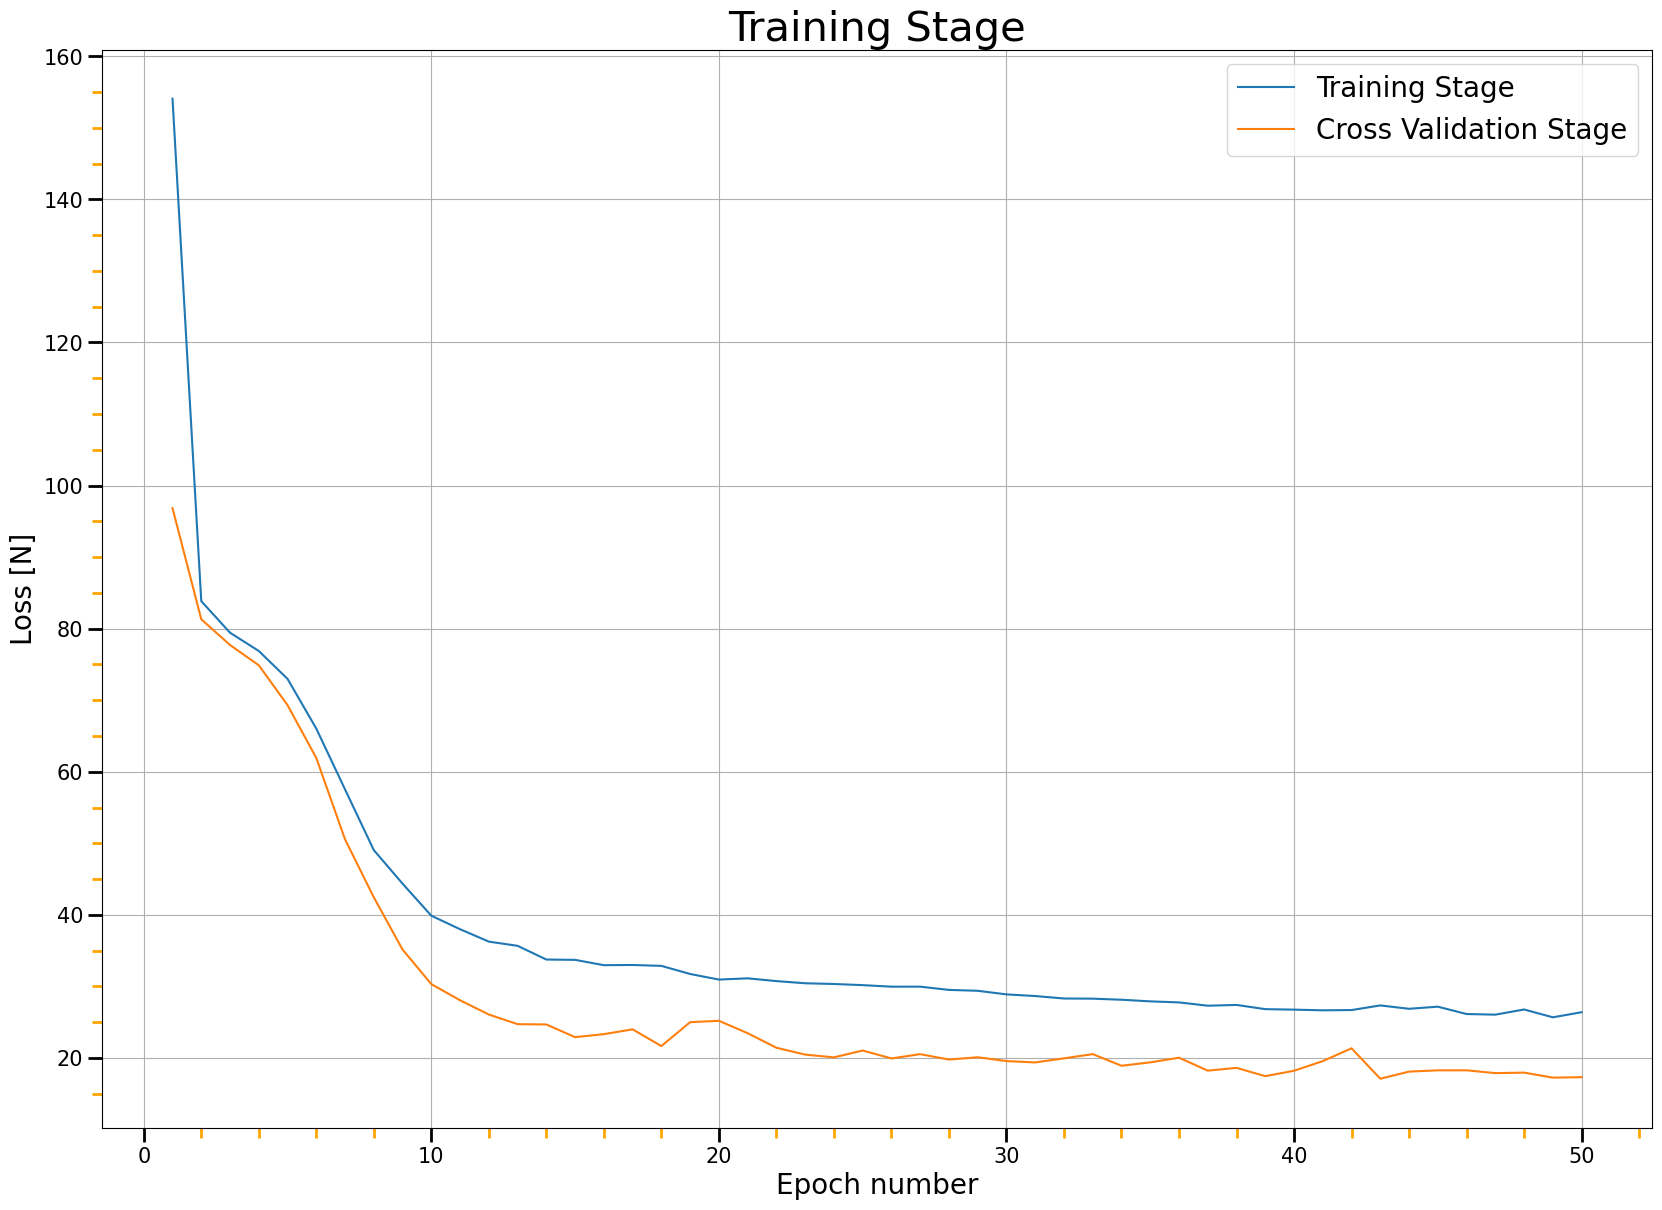

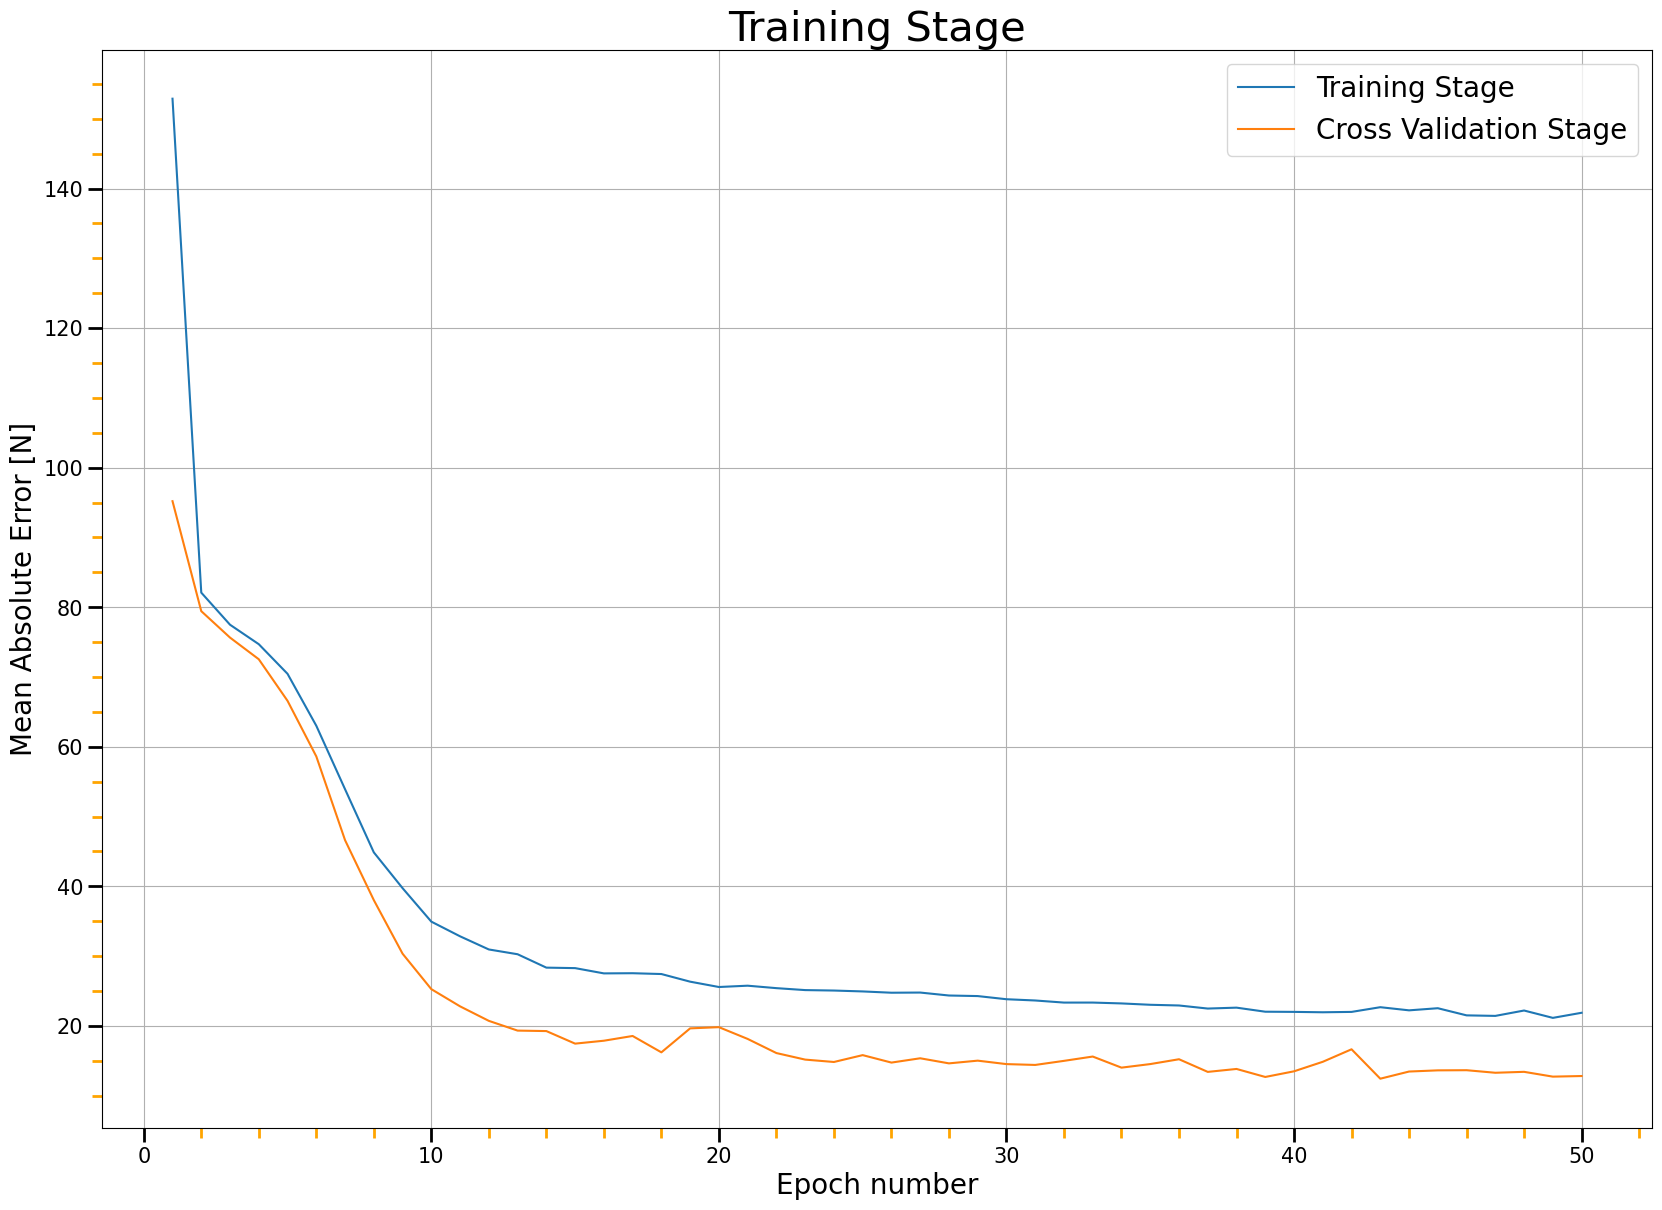

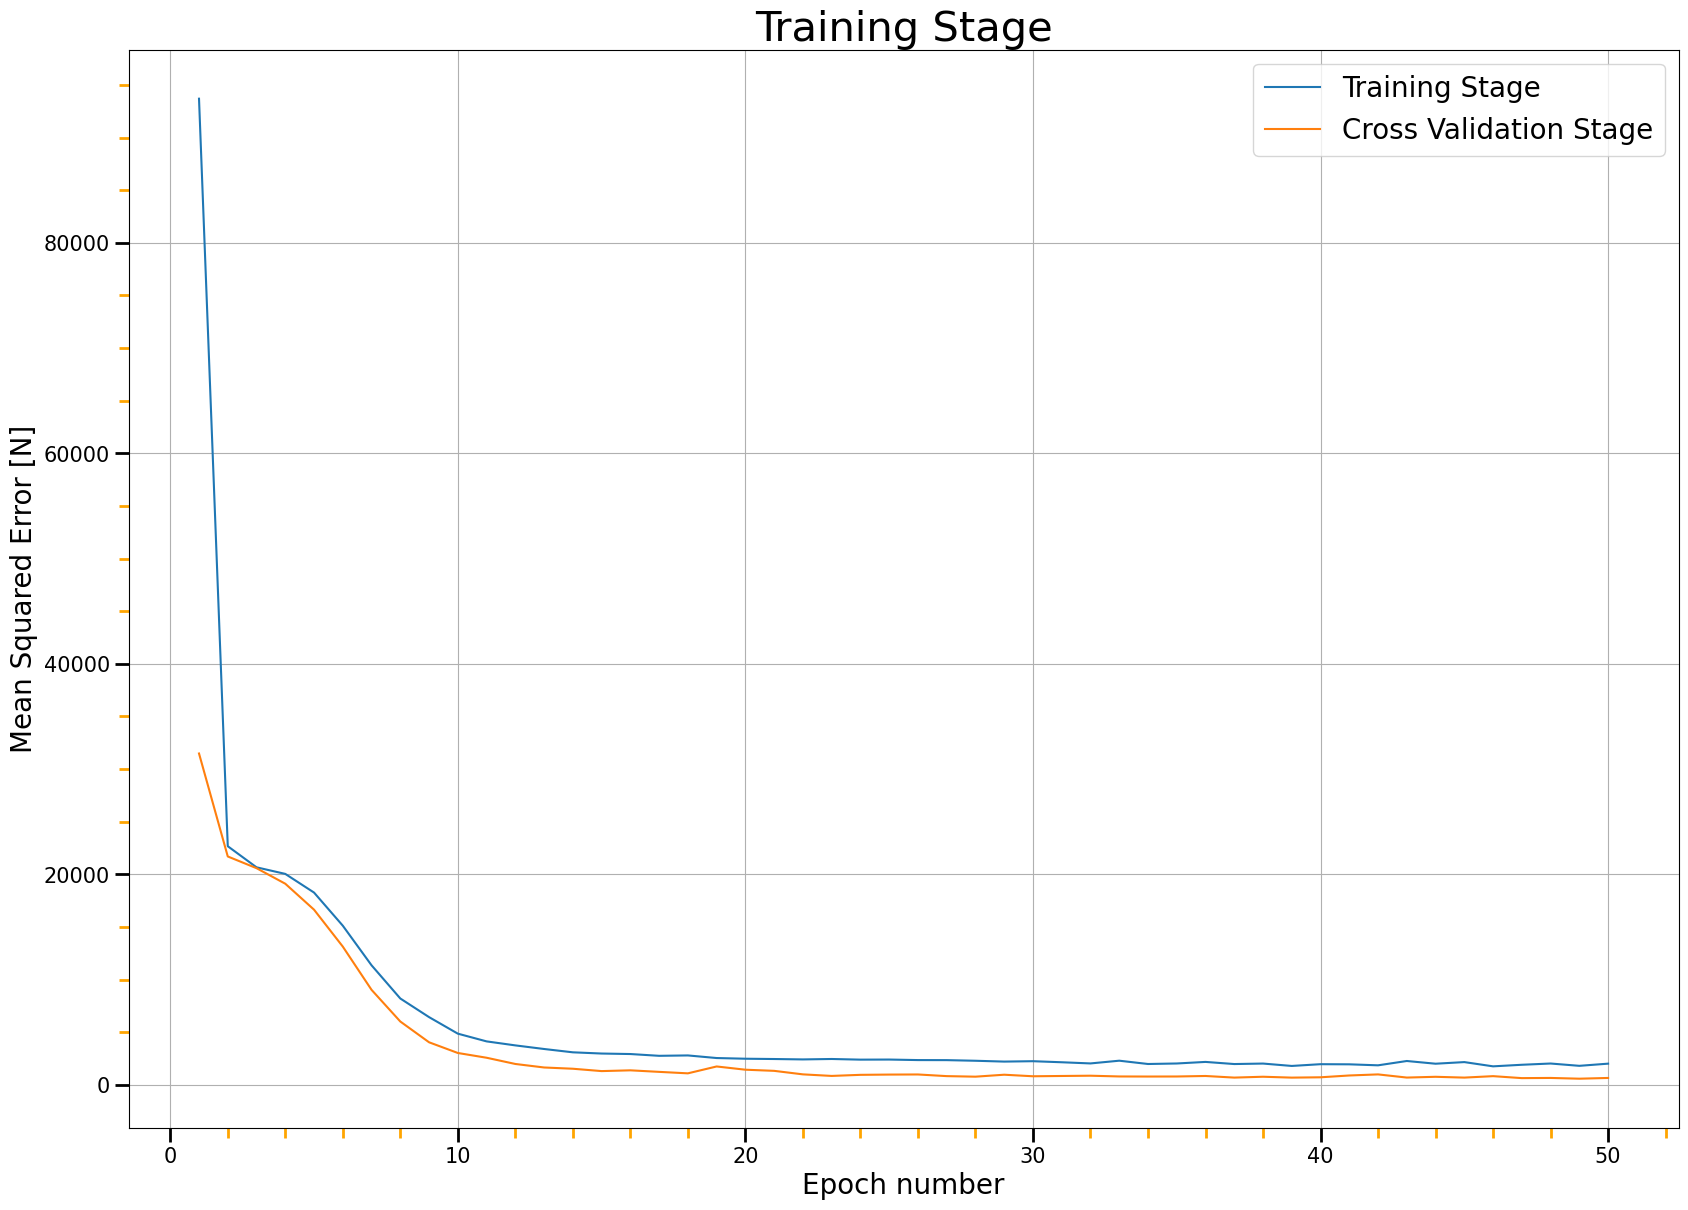

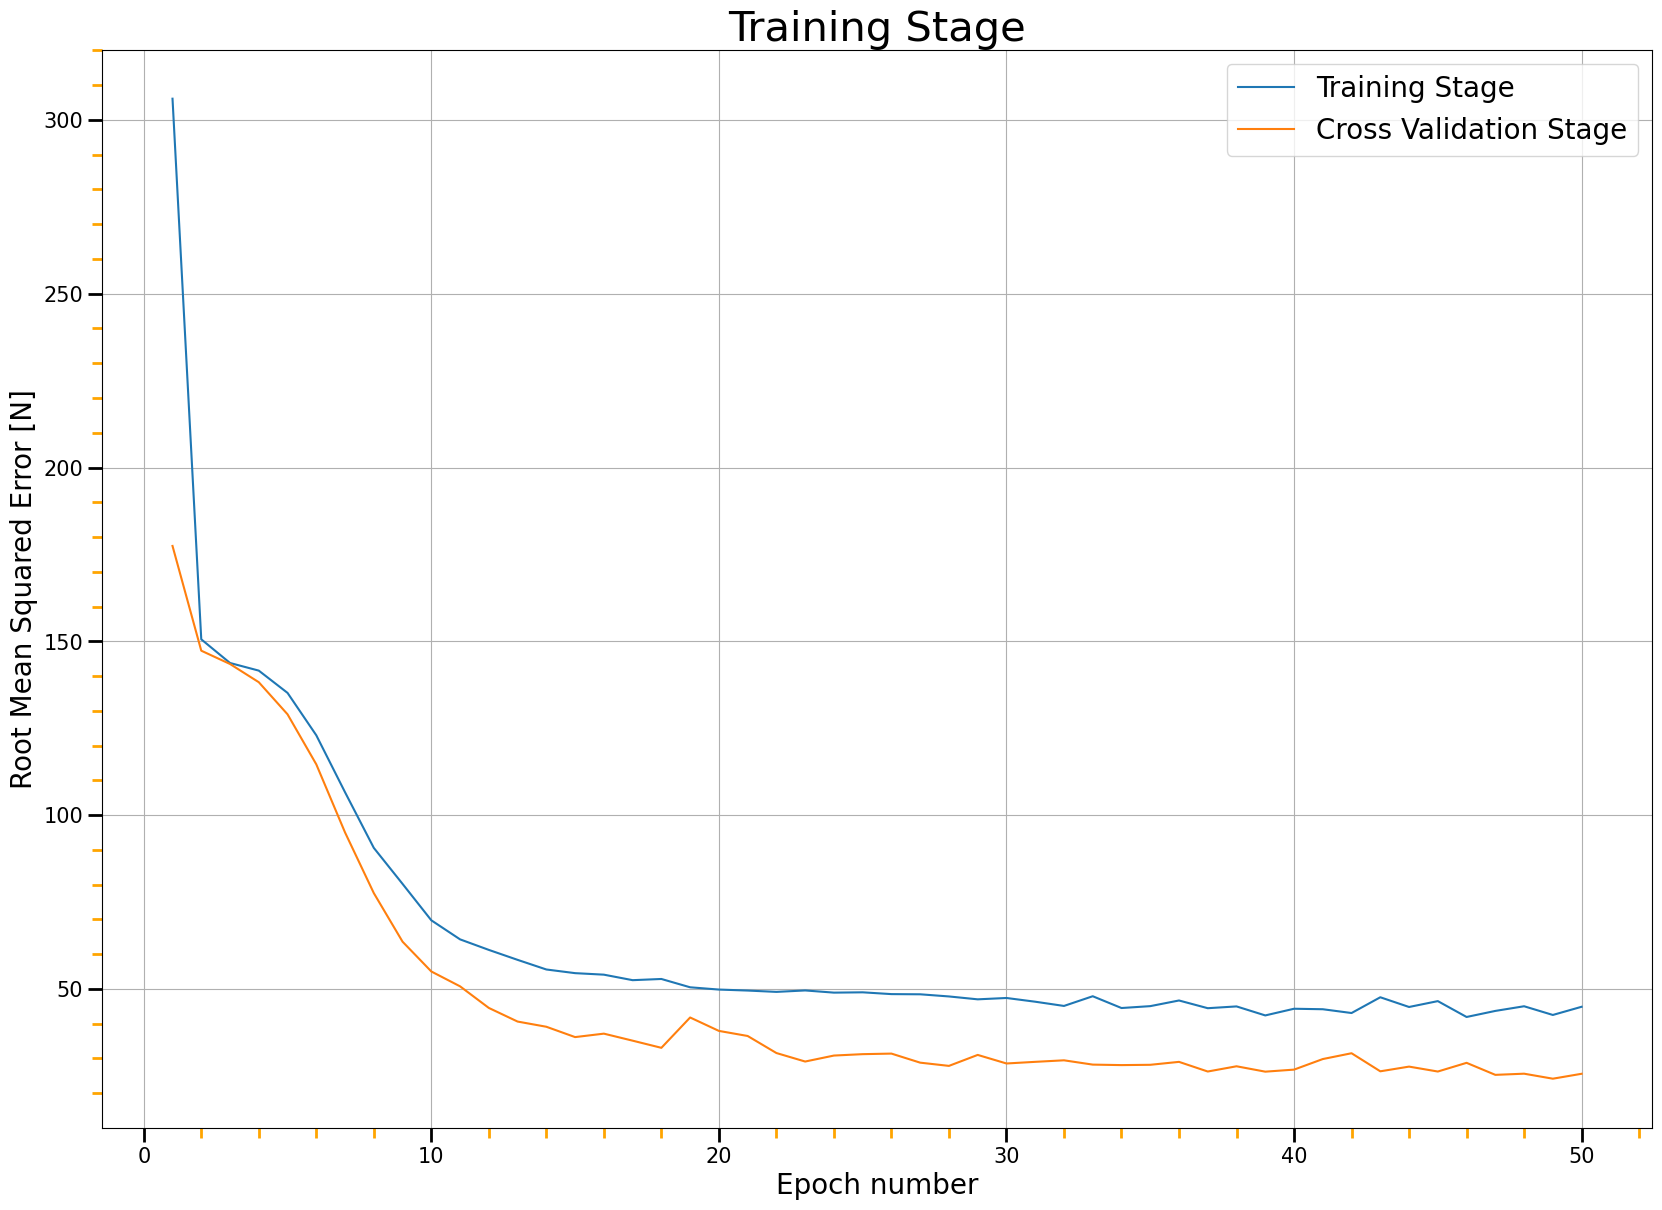

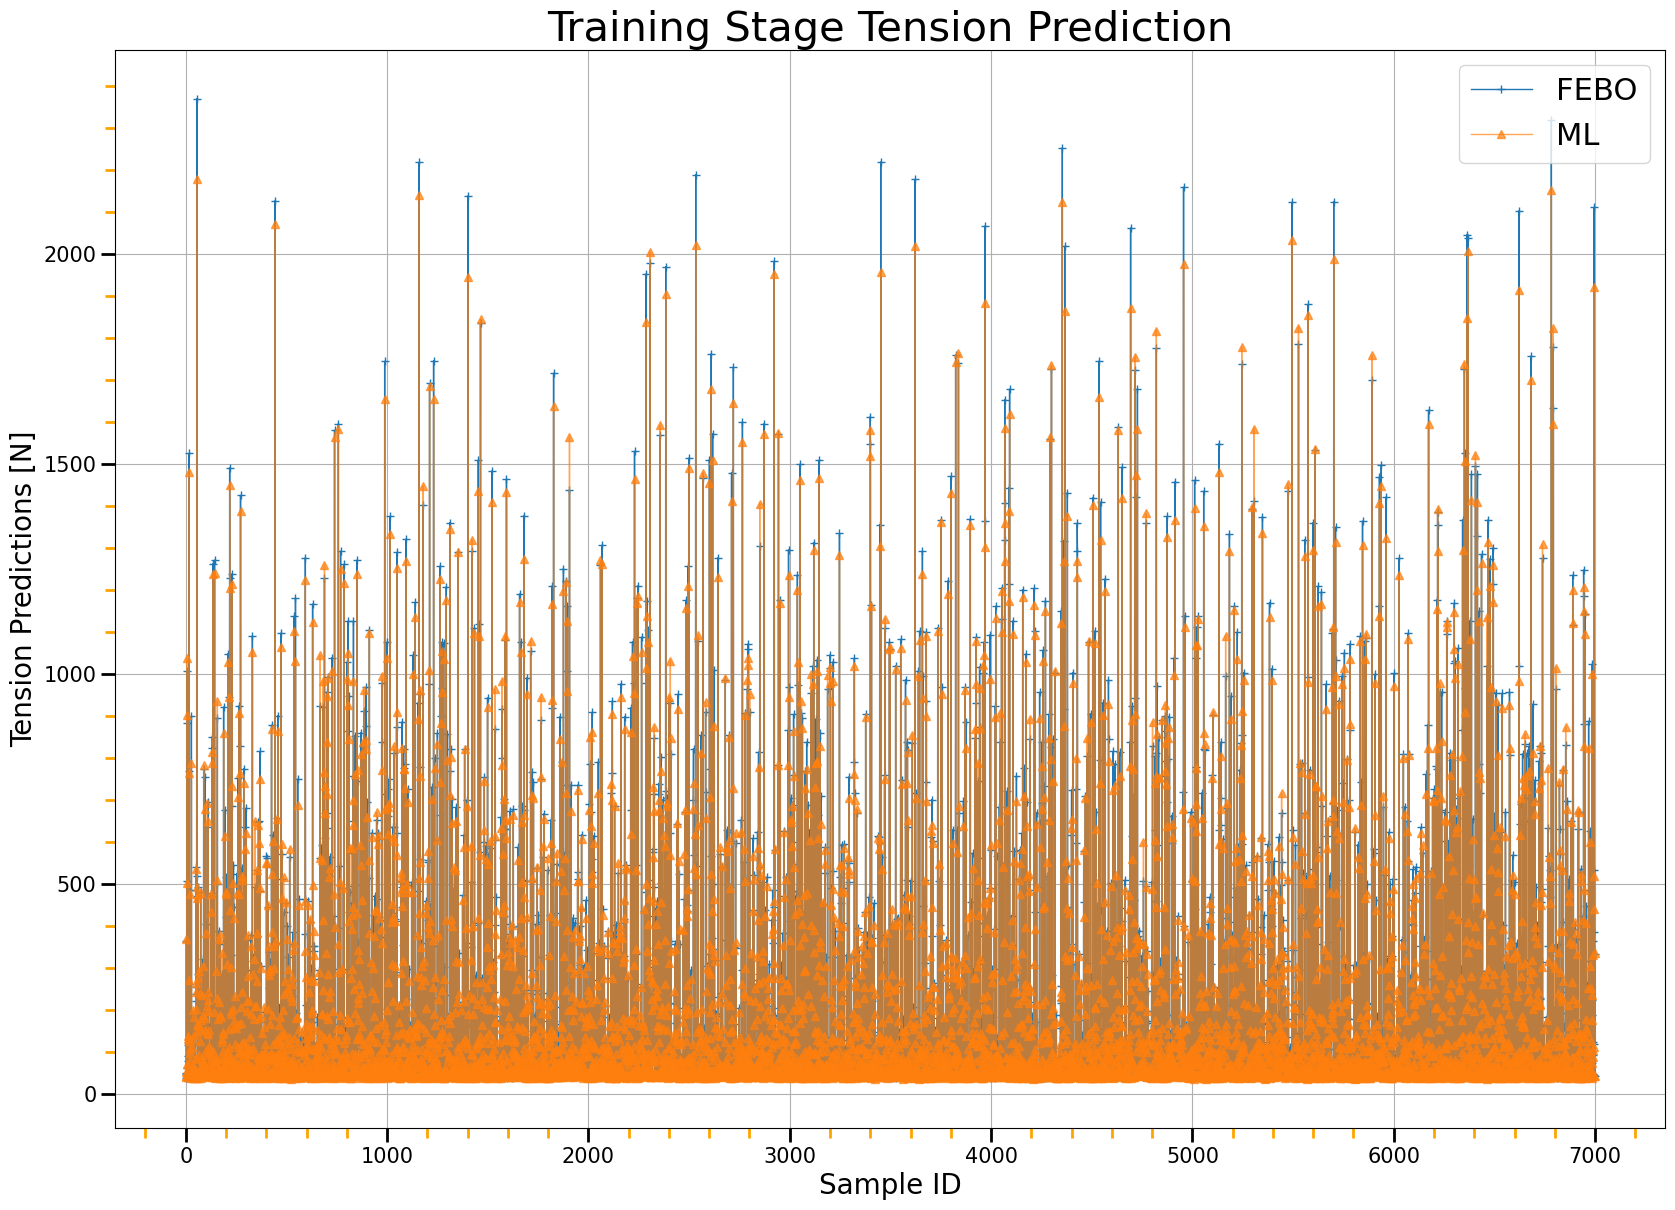

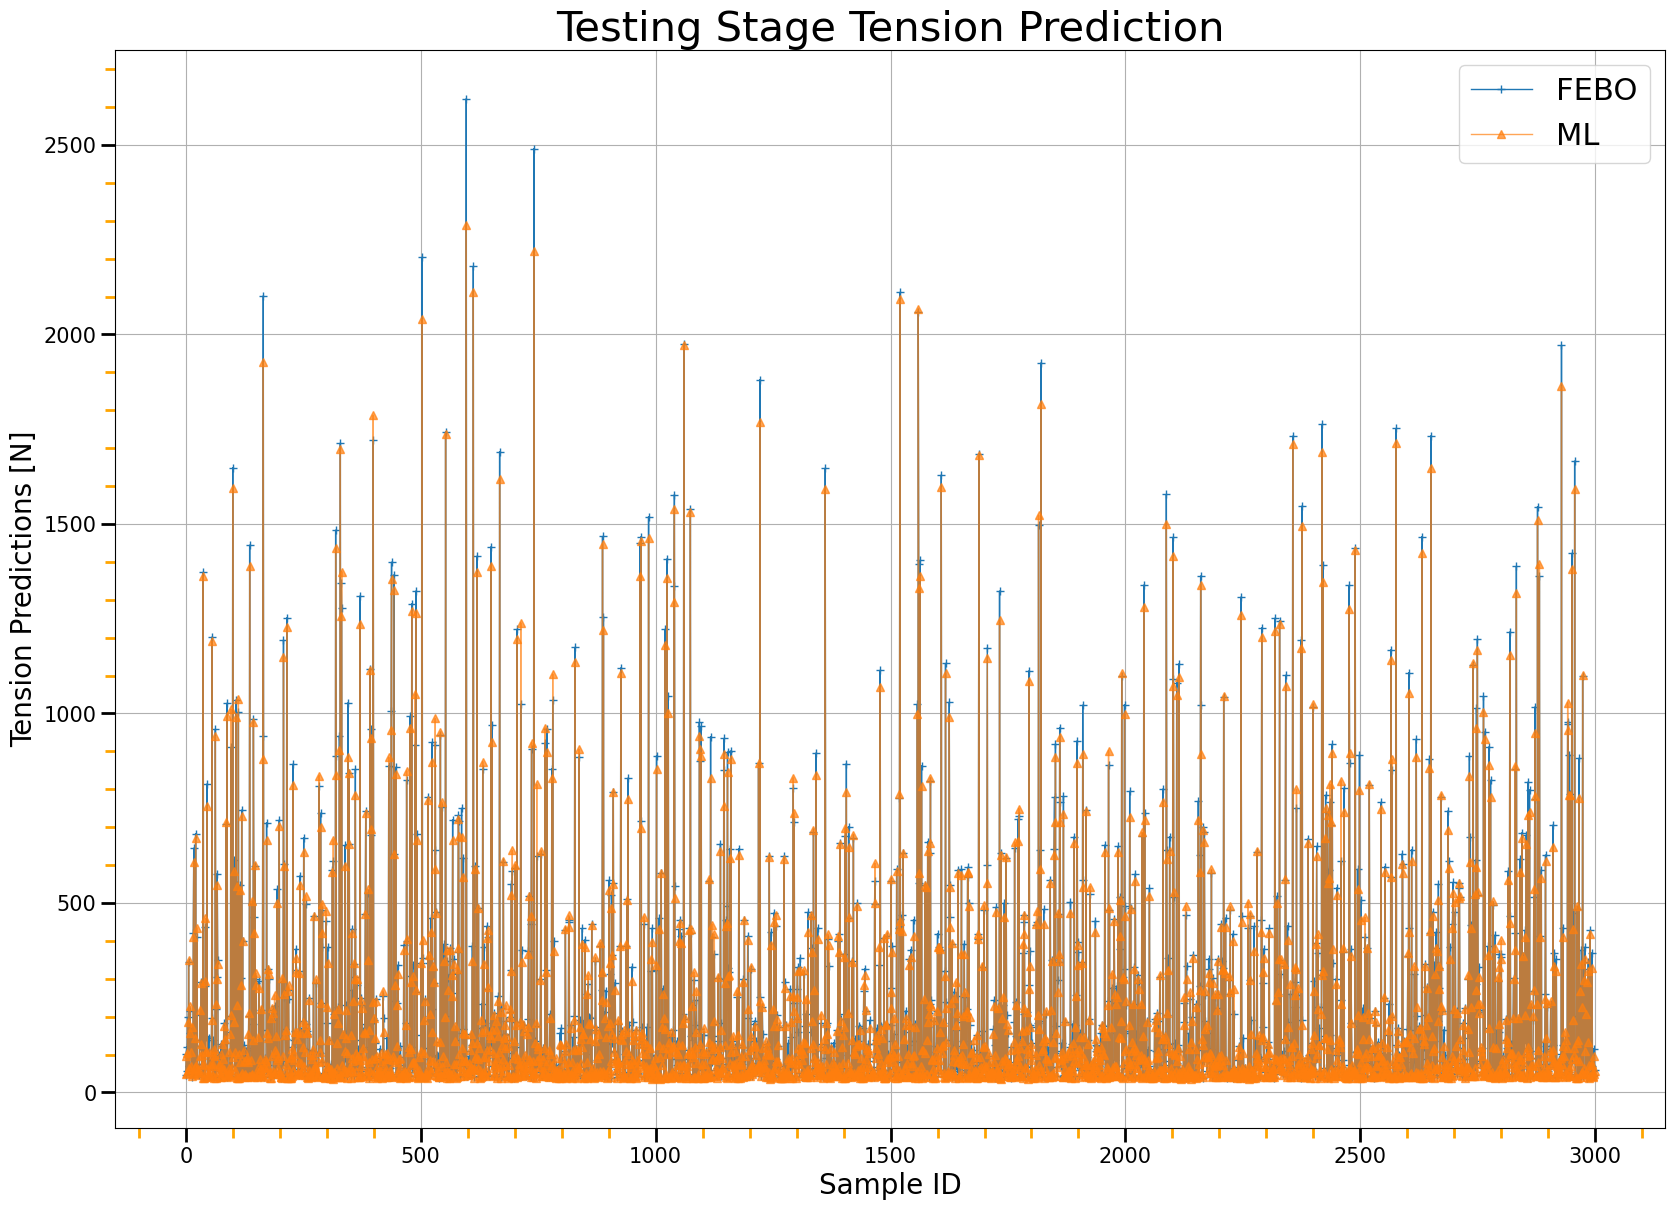

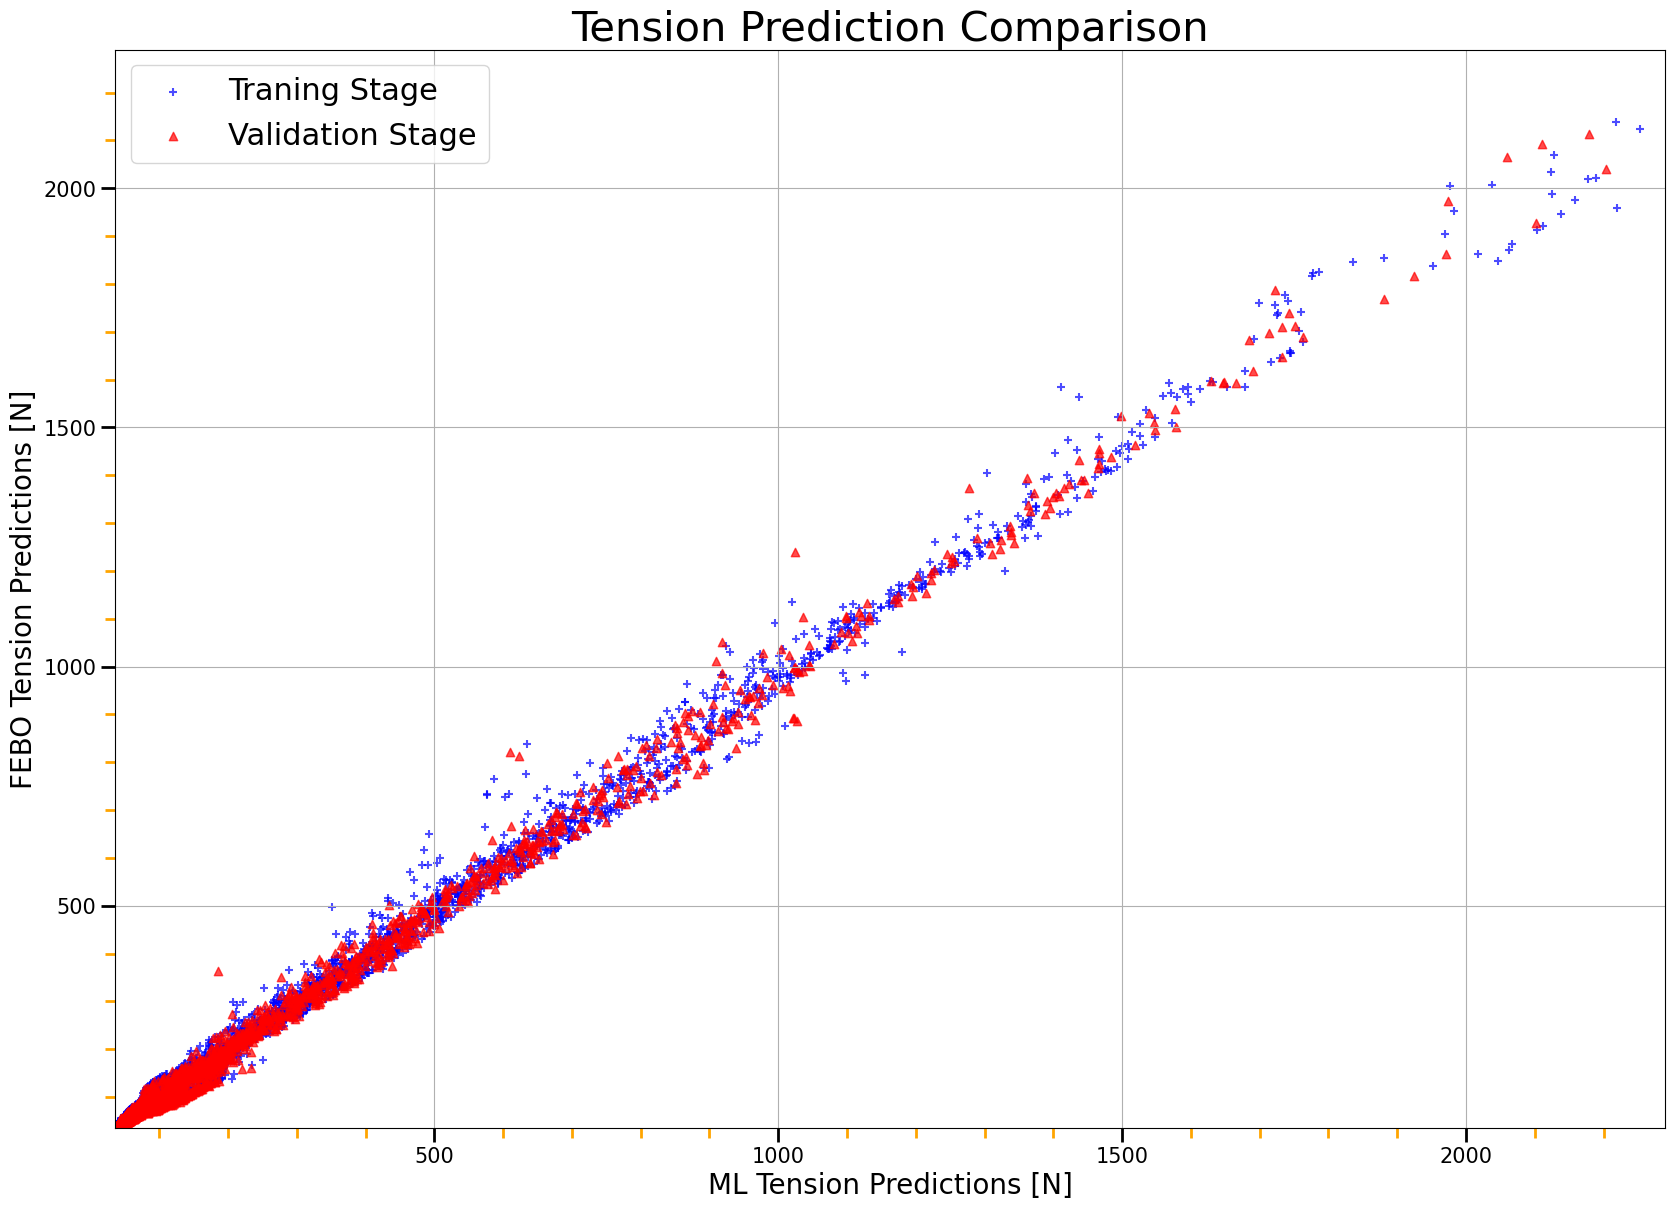

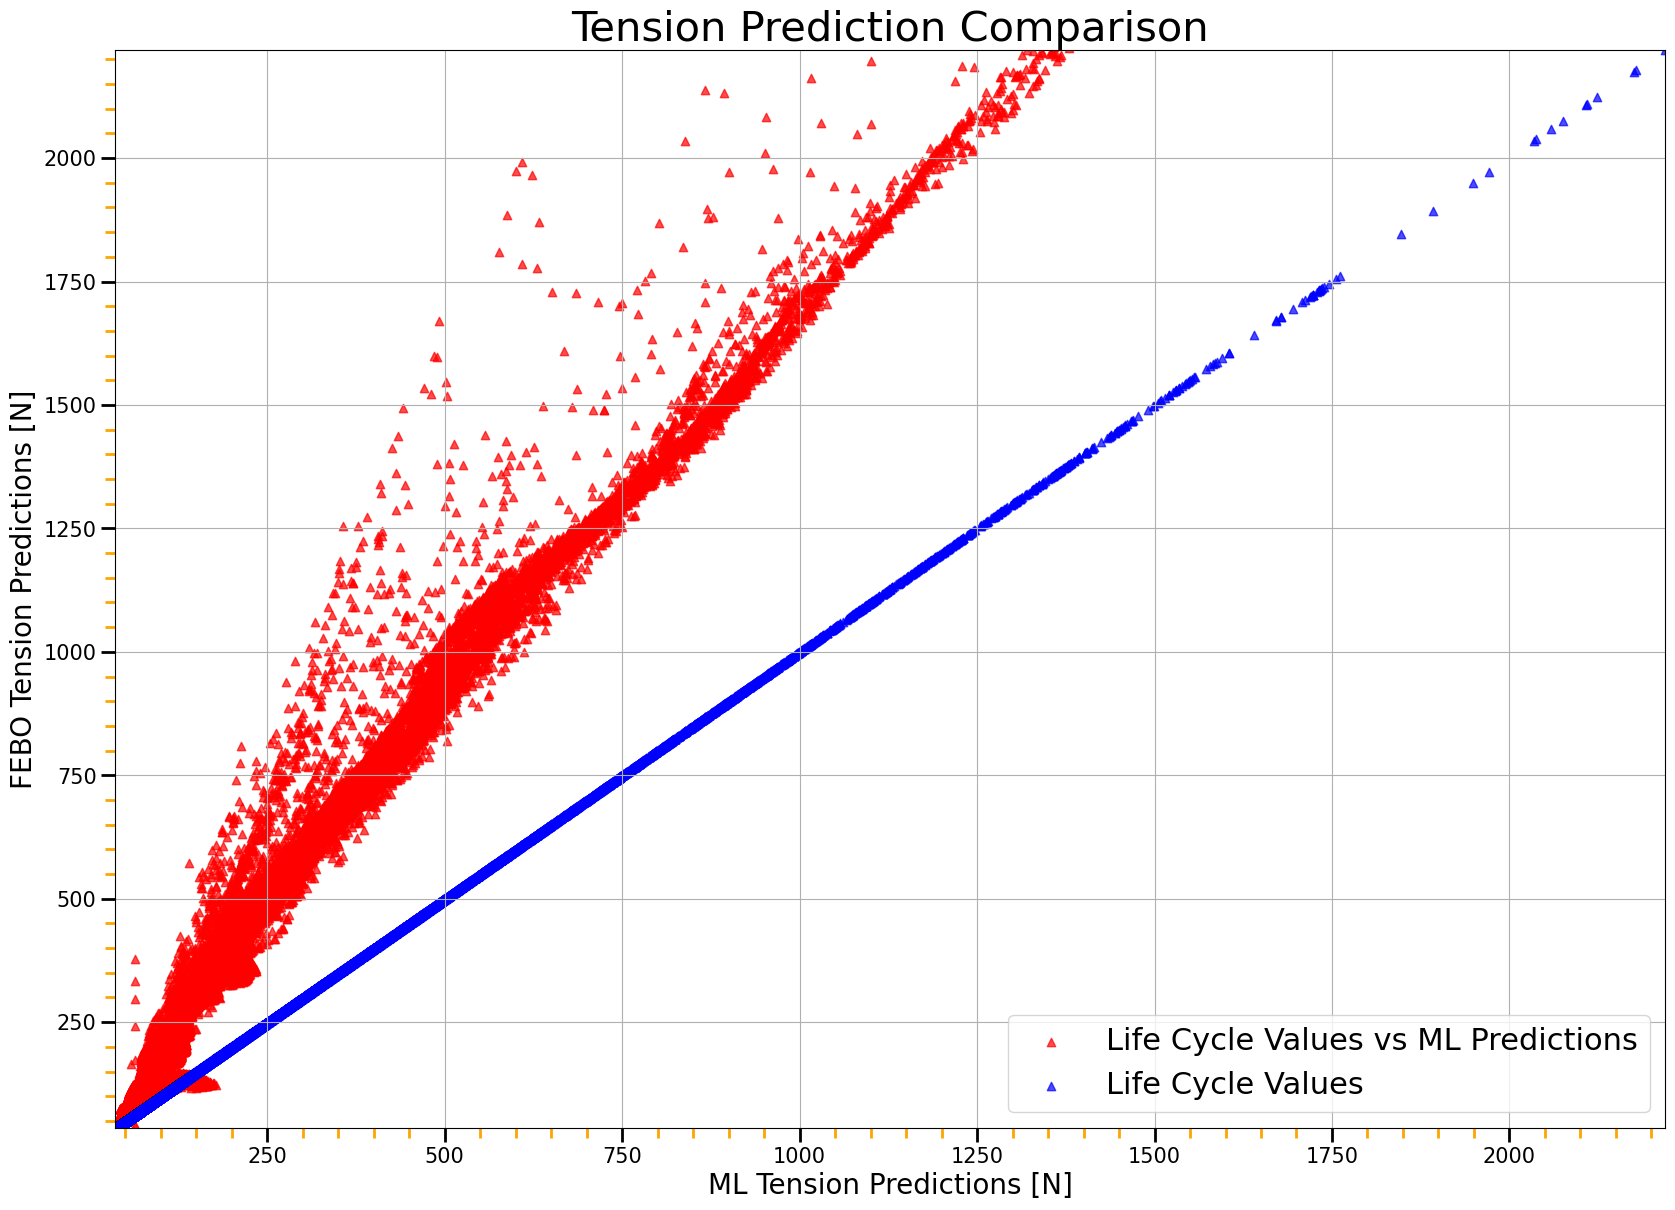

In [53]:
#
"""
lossVec     = log_rgr.history["loss"]
val_lossVec = log_rgr.history["val_loss"]
maeVec      = log_rgr.history[lossFunctionHist[0]]
val_maeVec  = log_rgr.history[val_lossFunctionHist[0]]
mseVec      = log_rgr.history[lossFunctionHist[1]]
val_mseVec  = log_rgr.history[val_lossFunctionHist[1]]
rmseVec     = log_rgr.history[lossFunctionHist[2]]
val_rmseVec = log_rgr.history[val_lossFunctionHist[2]]
label       = lossFunctionHist
modelName   = f"{l_architecture}_{nn_out}__{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}"
figName     = f"{l_architecture}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v4.jpg"
#
# lets check for overfitting
train_loss = NN_rgr_v2.evaluate(X_train, y_train, verbose=1)
test_loss  = NN_rgr_v2.evaluate(X_test, y_test, verbose=1)
lifeCycle_loss = NN_rgr_v2.evaluate(X_lifeCycle,y_lifeCycle, verbose=1)
print(f'loss [N] in training stage: {train_loss[0]:.2f}')
print(f'loss [N] in testing stage: {test_loss[0]:.2f}')
print(f'loss [N] in life cycle: {lifeCycle_loss[0]:.2f}')
print(f'{lossFunctionHist[0].replace("_"," ").title()} [N] in training stage: {train_loss[1]:.2f}')
print(f'{lossFunctionHist[0].replace("_"," ").title()} [N] in testing stage: {test_loss[1]:.2f}')
print(f'{lossFunctionHist[0].replace("_"," ").title()} [N] in life cycle: {lifeCycle_loss[1]:.2f}')
#
print(f'{lossFunctionHist[1].replace("_"," ").title()} [N] in training stage: {train_loss[2]:.2f}')
print(f'{lossFunctionHist[1].replace("_"," ").title()} [N] in testing stage: {test_loss[2]:.2f}')
print(f'{lossFunctionHist[1].replace("_"," ").title()} [N] in life cycle: {lifeCycle_loss[2]:.2f}')
#
print(f'{lossFunctionHist[2].replace("_"," ").title()} [N] in training stage: {train_loss[3]:.2f}')
print(f'{lossFunctionHist[2].replace("_"," ").title()} [N] in testing stage: {test_loss[3]:.2f}')
print(f'{lossFunctionHist[2].replace("_"," ").title()} [N] in life cycle: {lifeCycle_loss[3]:.2f}')
"""
#

#
modelName   = f"{l_architecture}_{nn_out}__{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}"
figName     = f"{l_architecture}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v4.jpg"
#
# lets check for overfitting
train_loss = NN_rgr_v2.evaluate(X_train, y_train, verbose=1)
test_loss  = NN_rgr_v2.evaluate(X_test, y_test, verbose=1)
lifeCycle_loss = NN_rgr_v2.evaluate(X_lifeCycle,y_lifeCycle, verbose=1)
#
# Now lets plot the testing data an compared it with the predictions from the neural network
predictions_train = NN_rgr_v2.predict(X_train)
predictions_test = NN_rgr_v2.predict(X_test)
predictions_lifeCycle = NN_rgr_v2.predict(X_lifeCycle)
#
#
write_Metrics(NN_rgr_v2,log_rgr,lossFunctionHist,train_loss,test_loss,lifeCycle_loss,modelName)
#
"""

#1 hidden layer#
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_train, y_train,f"Training_Stage")
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_test, y_test,f"Testing_Stage")
plot_ml_regressor_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_train, y_train,predictions_test, y_test)
plot_ml_regressor_lifeCycle_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_lifeCycle_{nn_1}_{nn_2}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_lifeCycle, y_lifeCycle)

#2 hidden layers
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_train, y_train,f"Training_Stage")
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_test, y_test,f"Testing_Stage")
plot_ml_regressor_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{alpha}_{nn_out}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_train, y_train,predictions_test, y_test)
plot_ml_regressor_lifeCycle_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_lifeCycle_{nn_1}_{nn_2}_{nn_3}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_lifeCycle, y_lifeCycle)

#3 hidden layers
plt.savefig(f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{nn_4}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg")
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{nn_4}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_train, y_train,f"Training_Stage")
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{nn_4}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_test, y_test,f"Testing_Stage")
plot_ml_regressor_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_{nn_1}_{nn_2}_{nn_3}_{nn_4}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_train, y_train,predictions_test, y_test)
plot_ml_regressor_lifeCycle_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_lifeCycle_{nn_1}_{nn_2}_{nn_3}_{nn_4}_{nn_out}_{nn_out}_{alpha}_{iter}_{batch}_{crossVal}_{lossFunction}_{optimizerFunction}_{activationFunction}_v3.jpg",predictions_lifeCycle, y_lifeCycle)
"""
plot_epoch_vs_loss(log_rgr.history["loss"],log_rgr.history["val_loss"],"loss",figName,figureSize)
plot_epoch_vs_loss(log_rgr.history[lossFunctionHist[0]],log_rgr.history[val_lossFunctionHist[0]],lossFunctionHist[0].replace("_"," ").title(),figName,figureSize)
plot_epoch_vs_loss(log_rgr.history[lossFunctionHist[1]],log_rgr.history[val_lossFunctionHist[1]],lossFunctionHist[1].replace("_"," ").title(),figName,figureSize)
plot_epoch_vs_loss(log_rgr.history[lossFunctionHist[2]],log_rgr.history[val_lossFunctionHist[2]],lossFunctionHist[2].replace("_"," ").title(),figName,figureSize)
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,figName,predictions_train, y_train,f"Training_Stage")
plot_ml_regressor_predictionVStarget_values_idSamples(figureSize,figName,predictions_test, y_test,f"Testing_Stage")
plot_ml_regressor_predictionVStarget_values(figureSize,figName,predictions_train, y_train,predictions_test, y_test)
plot_ml_regressor_lifeCycle_predictionVStarget_values(figureSize,f"mnn_tensorflow_maxTensions_test_lifeCycle_{figName}",predictions_lifeCycle, y_lifeCycle)

#
#
# Show the model architecture
NN_rgr_v2.summary()
#lets save the model
NN_rgr_v2.save(f'{modelName}.keras')
#Lets load the model
NN_rgr_v2_loaded = tf.keras.models.load_model(f'{modelName}.keras')
# Show the model architecture
NN_rgr_v2_loaded.summary()